In [185]:
import pandas as pd
import os
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import stats
import matplotlib
from matplotlib.dates import DateFormatter
import matplotlib.dates as md
import datetime as dt
from pivottablejs import pivot_ui
from IPython.display import HTML
import seaborn as sns
import rpy2
import pickle
import matplotlib as mp
from IPython.display import display, HTML
from PIL import Image
from scipy import stats as st
from scipy.stats import t
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from dask.distributed import Client
from dask.distributed import as_completed
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200
#import qgrid
#import ipywidgets as widgets

In [186]:
def time_to_int(dateobj):
    total = int(dateobj.strftime('%S'))
    total += int(dateobj.strftime('%M')) * 60
    total += int(dateobj.strftime('%H')) * 60 * 60
    total += (int(dateobj.strftime('%j')) - 1) * 60 * 60 * 24
    total += (int(dateobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return total

def myfunc(x):
    return slope * x + intercept

In [187]:
import numpy as np

class expanding_window(object):
    '''	
    Parameters 
    ----------
    
    Note that if you define a horizon that is too far, then subsequently the split will ignore horizon length 
    such that there is validation data left. This similar to Prof Rob hyndman's TsCv 
    
    
    initial: int
        initial train length 
    horizon: int 
        forecast horizon (forecast length). Default = 1
    period: int 
        length of train data to add each iteration 
    '''
    

    def __init__(self,initial= 1,horizon = 1,period = 1):
        self.initial = initial
        self.horizon = horizon 
        self.period = period 


    def split(self,data):
        '''
        Parameters 
        ----------
        
        Data: Training data 
        
        Returns 
        -------
        train_index ,test_index: 
            index for train and valid set similar to sklearn model selection
        '''
        self.data = data
        self.counter = 0 # for us to iterate and track later 


        data_length = data.shape[0] # rows 
        data_index = list(np.arange(data_length))
         
        output_train = []
        output_test = []
        # append initial 
        output_train.append(list(np.arange(self.initial)))
        progress = [x for x in data_index if x not in list(np.arange(self.initial)) ] # indexes left to append to train 
        output_test.append([x for x in data_index if x not in output_train[self.counter]][:self.horizon] )
        # clip initial indexes from progress since that is what we are left 
         
        while len(progress) != 0:
            temp = progress[:self.period]
            to_add = output_train[self.counter] + temp
            # update the train index 
            output_train.append(to_add)
            # increment counter 
            self.counter +=1 
            # then we update the test index 
            
            to_add_test = [x for x in data_index if x not in output_train[self.counter] ][:self.horizon]
            output_test.append(to_add_test)

            # update progress 
            progress = [x for x in data_index if x not in output_train[self.counter]]	
            
        # clip the last element of output_train and output_test
        output_train = output_train[:-1]
        output_test = output_test[:-1]
        
        # mimic sklearn output 
        index_output = [(train,test) for train,test in zip(output_train,output_test)]
        
        return index_output

In [188]:
def evaluate_ets(npa_):
    train = npa_[0]
    test = npa_[1]
    
    ets_TT=sm.tsa.statespace.ExponentialSmoothing(np.log(train),initialization_method='heuristic',seasonal=52,trend=True,damped_trend=True).fit()
    ets_FT=sm.tsa.statespace.ExponentialSmoothing(np.log(train),initialization_method='heuristic',seasonal=52,trend=False,damped_trend=True).fit()
    ets_TF=sm.tsa.statespace.ExponentialSmoothing(np.log(train),initialization_method='heuristic',seasonal=52,trend=True,damped_trend=False).fit()
    ets_FF=sm.tsa.statespace.ExponentialSmoothing(np.log(train),initialization_method='heuristic',seasonal=52,trend=False,damped_trend=False).fit()
    #arima_model = auto_arima(train, start_p=0, start_d=0, start_q=0,max_p=3, max_d=3, max_q=5, start_P=0, start_D=0, start_Q=0, max_P=3, max_D=3, max_Q=3, m=52, seasonal=True, stepwise=True, n_fits=50)

    #labels_ = list()
    fc_ets_TT = np.exp(ets_TT.forecast(13)) #inverting the Log
    fc_ets_FT = np.exp(ets_FT.forecast(13)) #inverting the Log
    fc_ets_TF = np.exp(ets_TF.forecast(13)) #inverting the Log
    fc_ets_FF = np.exp(ets_FF.forecast(13)) #inverting the Log

    rmse_TT = mean_squared_error(test, fc_ets_TT, squared=True)
    rmse_FT = mean_squared_error(test, fc_ets_FT, squared=True)
    rmse_TF = mean_squared_error(test, fc_ets_TF, squared=True)
    rmse_FF = mean_squared_error(test, fc_ets_FF, squared=True)
    return([rmse_TT, rmse_FT, rmse_TF, rmse_FF])

In [189]:
db_filename = 'todo.db'

db_is_new = not os.path.exists(db_filename)

conn = sqlite3.connect(db_filename)

if db_is_new:
    print('Need to create schema')
else:
    print('Database exists, assume schema does, too.')

conn.close()

Database exists, assume schema does, too.


In [190]:
si = ['03-31','06-30','09-30','12-31']
               
[start,end, prices_df, sp1500_index_df, sp500, sp600, sp400, market_data, completed_fred_pvt, completed_bonds, completed_bonds_pvt, sectors, indexes, screener_sorted] = pickle.load(open('./data_object.pkl', 'rb'))

prices = prices_df
#prices = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500_Sectors_Indexes_Prices")

In [191]:
def colored(r, g, b, text):
    return f"\033[38;2;{r};{g};{b}m{text}\033[0m"

In [192]:
def display_side_by_side(dfs:list, captions:list, tablespacing=5):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    for (caption, df) in zip(captions, dfs):
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += tablespacing * "\xa0"
    display(HTML(output))

In [193]:
import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')
nyse_dates = nyse.schedule(start_date=start, end_date=end)
"""
pd.to_datetime(idx2, errors='coerce')
df.index = pd.to_datetime(df.index, errors='coerce',format='%Y-%m-%d')
df = df.interpolate(method='time')

frequency = nyse_trading_dates.rename_axis([None]).index

df = prices.rename_axis([None]).reindex(frequency)

for d in prices.rename_axis([None]).index:
    df.loc[d] = prices.loc[d]

df.interpolate(method='linear')

#nyse_trading_dates.reset_index().set_index('index').rename_axis([None]).index
"""

"\npd.to_datetime(idx2, errors='coerce')\ndf.index = pd.to_datetime(df.index, errors='coerce',format='%Y-%m-%d')\ndf = df.interpolate(method='time')\n\nfrequency = nyse_trading_dates.rename_axis([None]).index\n\ndf = prices.rename_axis([None]).reindex(frequency)\n\nfor d in prices.rename_axis([None]).index:\n    df.loc[d] = prices.loc[d]\n\ndf.interpolate(method='linear')\n\n#nyse_trading_dates.reset_index().set_index('index').rename_axis([None]).index\n"

In [194]:
#stock_fundamentals = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Stock_Fundamentals")
stock_fundamentals = market_data

In [195]:
#market_data

In [196]:
#print(stock_fundamentals)

In [197]:

import warnings
warnings.filterwarnings("ignore")

# load dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit()
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
    

# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)


In [198]:
#stock_fundamentals[stock_fundamentals.set_index(stock_fundamentals.iloc[:, 0]).index=='VOX']


In [199]:
#prices[prices['Symbol']=='VOX'].set_index('Date')

In [200]:
#plt.plot(prices[prices['Symbol']=='VOX'].set_index('Date')['Adj Close'])

In [201]:
#screener = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Screener")
screener = screener_sorted


In [202]:
#screener.set_index('Symbol').loc['BA']

In [203]:
#fundamentals = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="Stock_Fundamentals")
#fundamentals.set_index(fundamentals.columns[0],inplace=True)
fundamentals = stock_fundamentals

In [204]:
"""
stock_indexes = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="SP1500")
stock_indexes.drop(stock_indexes.columns[0], axis=1, inplace=True)
stock_indexes.set_index(stock_indexes.columns[0],inplace=True)
stock_indexes
"""
stock_indexes = sp1500_index_df

In [205]:
"""
spdr_indexes = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="spdr_indexes")
#vanguard_sectors.drop(vanguard_sectors.columns[0], axis=1, inplace=True)
spdr_indexes.set_index(spdr_indexes.columns[0],inplace=True)
spdr_indexes.columns=['Symbol']
spdr_indexes
"""
spdr_indexes = indexes
spdr_indexes.columns=['Symbol']
#spdr_indexes

In [206]:
"""
vanguard_sectors = pd.read_excel('SP1500_screener_multiple.xlsx',sheet_name="vanguard_sectors")
#vanguard_sectors.drop(vanguard_sectors.columns[0], axis=1, inplace=True)
vanguard_sectors.set_index(vanguard_sectors.columns[0],inplace=True)
vanguard_sectors.columns=['Symbol']
vanguard_sectors
"""
vanguard_sectors = sectors
vanguard_sectors.columns=['Symbol']
#vanguard_sectors

In [207]:
sector_performance_return = pd.DataFrame()
sector_performance_Q_smoothed_return = pd.DataFrame()

for v in [*spdr_indexes['Symbol'],*vanguard_sectors['Symbol']]:
    subset = prices[prices['Symbol'] == v]
    #subset_ = subset.set_index('Date').asfreq('Q')[['Adj Close']].pct_change()
    subset_ = subset.asfreq('D').interpolate().asfreq('Q')[['Adj Close']].pct_change()
    #print(subset_)
    #subset_qs = subset.set_index('Date')[['Adj Close']].pct_change().rolling(63).mean()
    subset_qs = subset[['Adj Close']].pct_change().rolling(63).mean()
    subset_.index = subset_.index.values.astype('M8[D]')
    subset_qs.index = subset_qs.index.values.astype('M8[D]')
    dt_str = subset_.index[-1].strftime('%Y-%m-%d')
    #tail = subset[subset.set_index('Date').index>=dt_str]
    tail = subset[subset.index>=dt_str]
    #dt_str = subset.set_index('Date').index[-1].strftime('%Y-%m-%d')
    dt_str = subset.index[-1].strftime('%Y-%m-%d')
    #tail_ = pd.DataFrame([(tail.set_index('Date')['Adj Close'][-1]-tail.set_index('Date')['Adj Close'][0])/tail.set_index('Date')['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    tail_ = pd.DataFrame([(tail['Adj Close'][-1]-tail['Adj Close'][0])/tail['Adj Close'][0]],index=[datetime.strptime(dt_str, '%Y-%m-%d')],columns=['Adj Close'])
    subset__ = pd.concat([subset_,tail_],axis=0)
    sector_performance_return = pd.concat([sector_performance_return,subset__],axis=1)
    sector_performance_Q_smoothed_return = pd.concat([sector_performance_Q_smoothed_return,subset_qs],axis=1)

In [208]:
sector_performance_Q_smoothed_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
sector_performance_return.columns = [*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]]
#display(sector_performance_Q_smoothed_return)
#display(sector_performance_return)

Seasonal Indexes


Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison
Current


standard deviations


03-31     06-30     09-30     12-31
SP1500                      0.134644  0.072380  0.037999  0.110320
SP500                       0.127411  0.070450  0.039033  0.106496
SP600                       0.199479  0.088447  0.037096  0.179394
SP400                       0.157662  0.100224  0.037075  0.138781
Communication Services ETF  0.138244  0.095192  0.045269  0.123434
Consumer Discretionary ETF  0.151791  0.146922  0.083611  0.127243
Consumer Staples ETF        0.096633  0.035421  0.049261  0.063730
Energy ETF                  0.369457  0.166709  0.099129  0.202483
Financials ETF              0.192299  0.053666  0.014462  0.140299
Health Care ETF             0.079810  0.054107  0.065798  0.098650
Industrials ETF             0.178470  0.072339  0.066050  0.134044
Information Technology ETF  0.135329  0.113409  0.054569  0.136753
Materials ETF               0.163483  0.099766  0.065317  0.127072
Real Estate ETF             0.161483  0.056090  0.032025  0.078165
Utilities ETF               0.092016  0.021473  0.033841  0.054883

t scores


03-31     06-30     09-30     12-31
SP1500                     -0.035281  0.505153  0.489908  0.202519
SP500                      -0.042087  0.512730  0.522980  0.210329
SP600                      -0.039834  0.407076  0.230960  0.144515
SP400                      -0.056330  0.357747  0.247928  0.166115
Communication Services ETF -0.106341  0.357027  0.223180  0.064848
Consumer Discretionary ETF -0.062503  0.366041  0.280865  0.185493
Consumer Staples ETF       -0.086371  0.447954  0.315992  0.322196
Energy ETF                  0.067680  0.258283 -0.179260  0.093682
Financials ETF             -0.048166  0.508740  0.933164  0.208614
Health Care ETF            -0.100433  0.650529  0.278976  0.215182
Industrials ETF            -0.027615  0.360421  0.307577  0.133187
Information Technology ETF  0.020546  0.480423  0.562966  0.220841
Materials ETF              -0.072960  0.371283  0.191302  0.206478
Real Estate ETF            -0.073157  0.604012  0.271246  0.220111
Utilities ETF              -0.006140  0.544116  0.518265  0.342246

p values


array([[<AxesSubplot:title={'center':'03-31'}>,
        <AxesSubplot:title={'center':'06-30'}>],
       [<AxesSubplot:title={'center':'09-30'}>,
        <AxesSubplot:title={'center':'12-31'}>]], dtype=object)

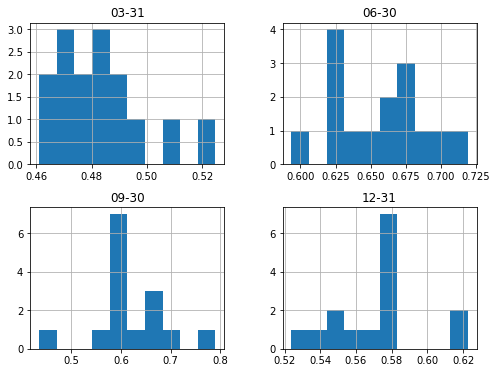

In [209]:
cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

std_indexes = pd.DataFrame()
seasonal_indexes = pd.DataFrame()

for spr in sector_performance_return.columns:
    #print(spr)
    s = sector_performance_return[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in sector_performance_return[spr].index:

        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes = pd.concat([std_indexes,ct_std],axis=1)
    seasonal_indexes = pd.concat([seasonal_indexes,ct],axis=1)

seasonal_indexes.columns = sector_performance_return.columns

std_indexes.columns = sector_performance_return.columns
    
seasonal_indexes = seasonal_indexes.T

std_indexes = std_indexes.T

si = ['03-31','06-30','09-30','12-31']

print("Seasonal Indexes")
"""
def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    #print(s)
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]
"""

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]
seasonal_index_values_sorted = []
seasonal_index_names_sorted = []
#B = seasonal_indexes[si]
for c in seasonal_indexes[si].columns:
    seasonal_index_values_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).values)
    seasonal_index_names_sorted.append(seasonal_indexes[si][c].sort_values(ascending=False).index.values)

temp_seasonal_index_values_sorted = pd.DataFrame(seasonal_index_values_sorted).T
temp_seasonal_index_values_sorted.columns = seasonal_indexes[si].columns

temp_seasonal_index_names_sorted = pd.DataFrame(seasonal_index_names_sorted).T
temp_seasonal_index_names_sorted.columns = seasonal_indexes[si].columns

A = temp_seasonal_index_values_sorted
B = temp_seasonal_index_names_sorted 
#B.columns = A.columns

display(B.style.apply(b_g,cmap=cm))

#A = seasonal_indexes[si]
#B = 
#display(df)

display(seasonal_indexes[si].style.background_gradient(cmap = cm,axis=0))

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
print("Current")

#A = seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False)
#B = seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False)
#display(B.style.apply(b_g,cmap=cm))
display(seasonal_indexes[seasonal_indexes.columns.difference(si)].sort_values(by=seasonal_indexes[seasonal_indexes.columns.difference(si)].columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))    

#calculate p-value
n=5
#print("means")
#display(seasonal_indexes[si])
print("standard deviations")
display(std_indexes[si])
t_scores = (seasonal_indexes[si])/(std_indexes[si]*np.sqrt(n))
print("t scores")
display(t_scores)
print("p values")
p_values = pd.DataFrame(t.cdf(t_scores, df=n-2),index=seasonal_indexes[si].index,columns=seasonal_indexes[si].columns)
def highlight_cells(val):
    color = 'yellow' if val <= .50 else 'green'
    #color = 'green' if val > .50 else ''
    return 'background-color: {}'.format(color)

display(p_values.style.applymap(highlight_cells))

p_values.hist()

#st.ttest_1samp(seasonal_indexes[si]/std_indexes[si],popmean=0,df=4-2)

#Ttest_1sampResult(statistic=0.36789006583267403, pvalue=0.714539654336473)

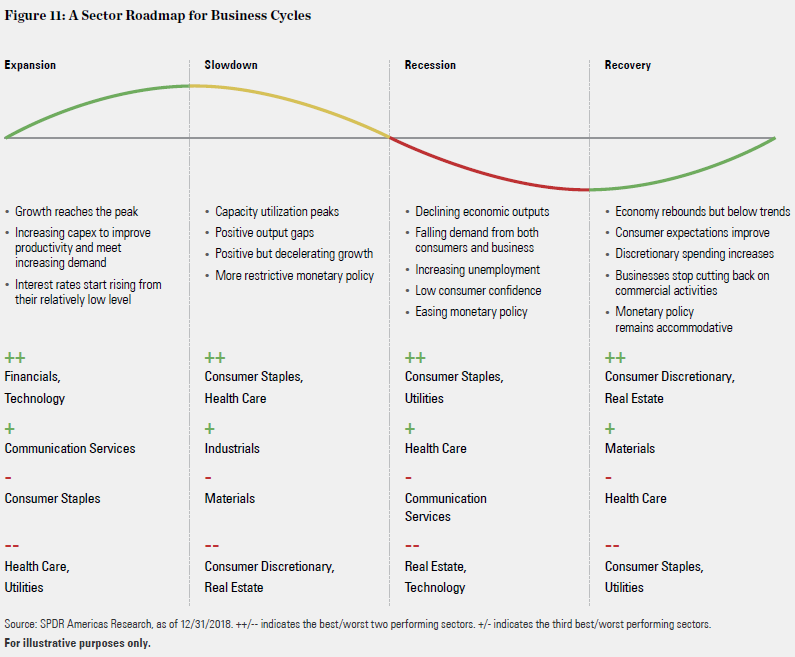

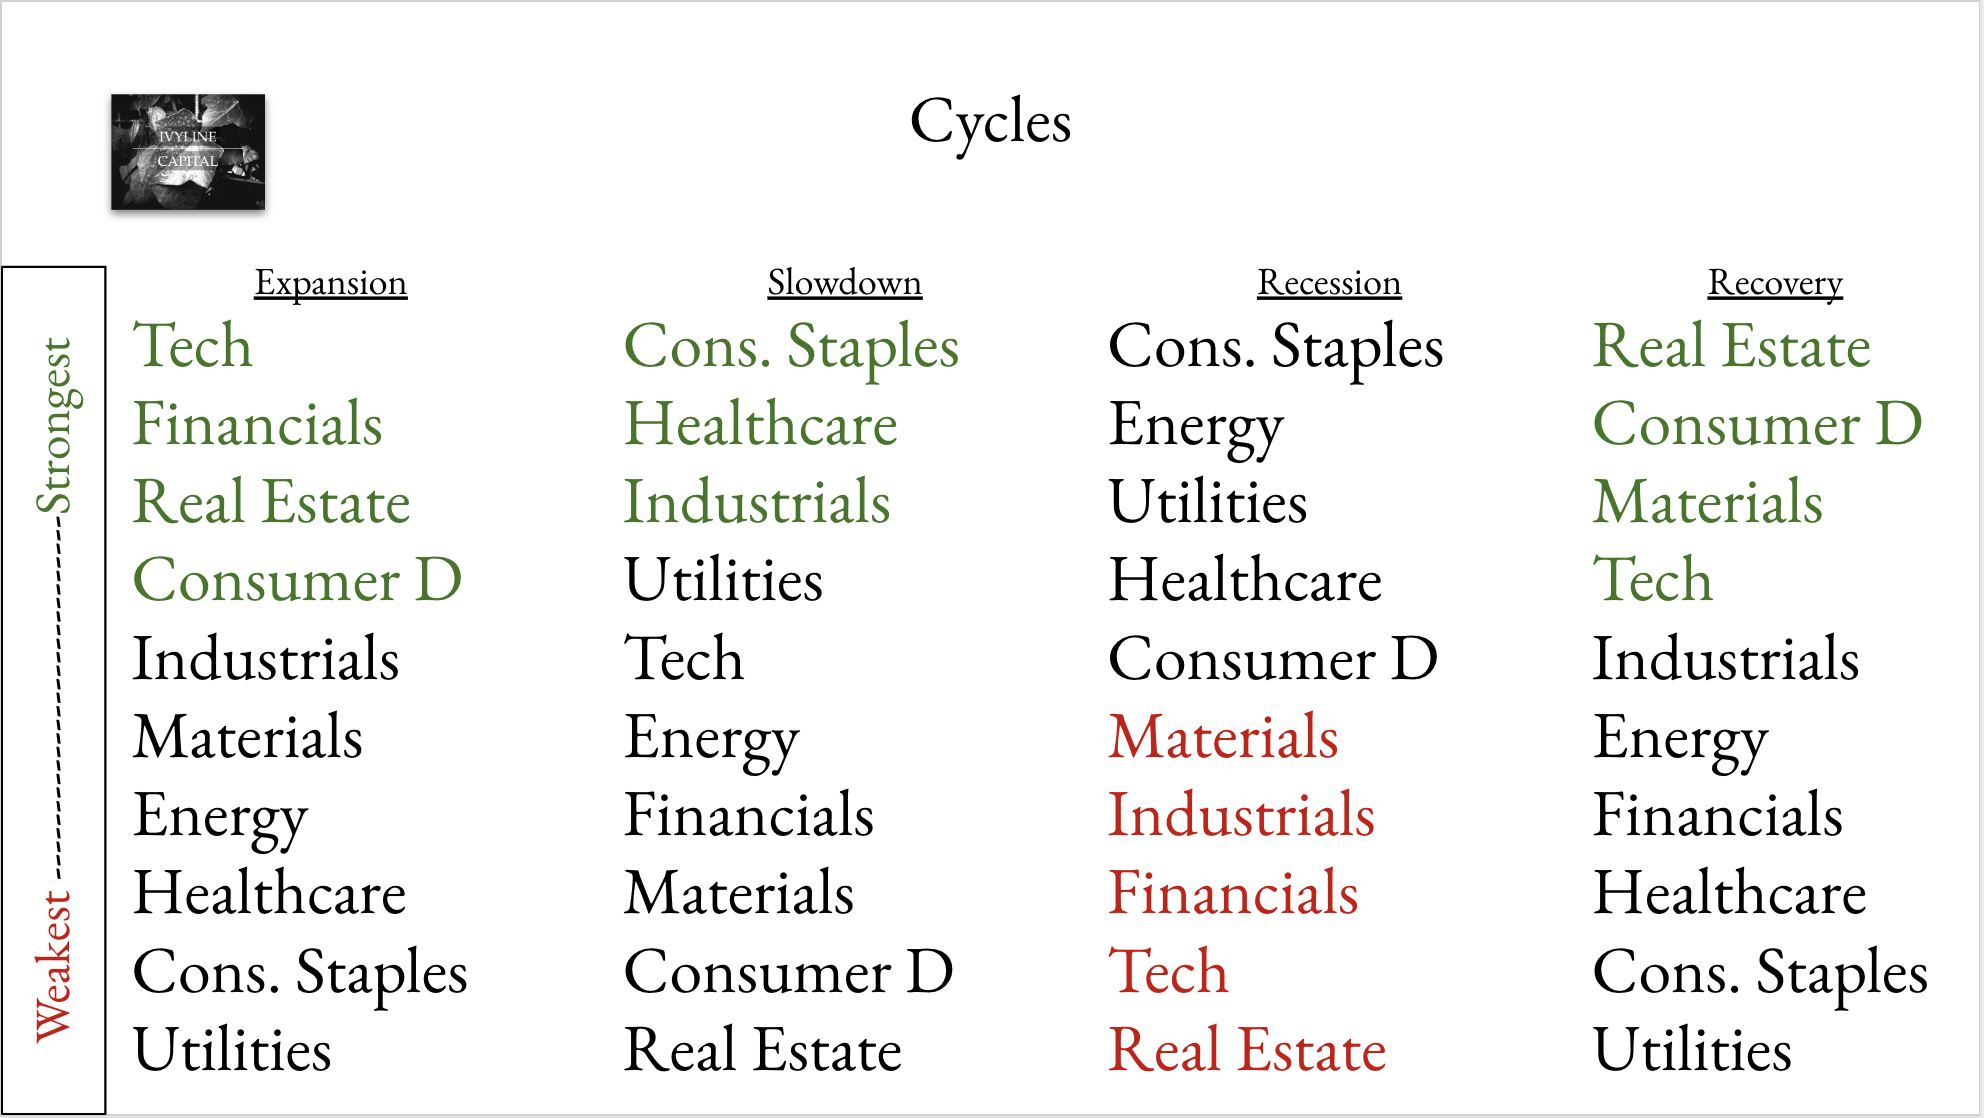

In [210]:
cycles_ = ['Expansion','Slowdown','Recession','Recovery']

path=r"C:\Users\User\Documents\wiki\wiki\dev\python\Python-Stock\reports\figures\Business cycles.png"
display(Image.open(path))
path=r"C:\Users\User\Documents\wiki\wiki\Finance\Business Cycles-2.png"
display(Image.open(path))

In [211]:
from scipy import stats as st
from scipy.stats import t

sector_performance_return_pvt = sector_performance_return[sector_performance_return.iloc[-1].sort_values(ascending=False).index]

sector_performance_return_pvt_heatmap = sector_performance_return_pvt.style.background_gradient(cmap = cm,axis=None)
display(sector_performance_return_pvt_heatmap)

sector_performances = pd.DataFrame()
sector_performances_values = pd.DataFrame()
for c in sector_performance_return.T.columns:
    #print(c)
    temp = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(sector_performance_return.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances = pd.concat([sector_performances,temp],axis=1)
    sector_performances_values = pd.concat([sector_performances_values,temp2],axis=1)
    #print(sector_performance_return[c].sort_values(ascending=False))
#display(sector_performances_values)
#sector_performances

def b_gfs(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    
    colors = [color for color in c]
    strings = []
    """
    for c in range(0,len(colors)):
        c_ = colors[c]
        strings.append(
    
    
    return **{
            'background-color': 'grey',
            'font-size': '20pt',
        }
    """
    return([*np.repeat('font-size: 7pt', len(colors), axis = None)])
    #print(['background-color: %s' % color for color in c])
    #print(['background-color: %s' % color + ', font-size: 7pt' for color in c])
    #return ['background-color: %s' % color for color in c]
    #return ['background-color: %s' % color + ', font-size: 7pt' for color in c]
    #return ['background-color: %s' % color for color in c,'font-size': '7pt']


def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    
    return ['background-color: %s' % color for color in c]
    
from pandas.io.formats.style import Styler
    
A = sector_performances_values
B = sector_performances

df = B.style.apply(b_g,cmap='RdYlGn')
#print(type(df.export()))
"""
df_styler_1 = df.export()
df_styler_2 = B.style.apply(b_g,cmap='RdYlGn').export()
Styler.use([df_styler_1])    
Styler.use([df_styler_2])
"""


#df.index = A.index
#sector_performances.style.background_gradient(cmap = cm,axis=1,)

display(df)


In [212]:
#cm = sns.color_palette("blend:red,yellow,green", as_cmap=True)
#pd.crosstab(shares_viz['Year'], shares_viz['Month'])

#seasonal_indexes[si]
seasonally_adjusted = pd.DataFrame()

for s in sector_performance_return.columns:
    
    s_ = pd.DataFrame(sector_performance_return[s])
    #print(sector_performance_return[s])
    years = []
    quarters = []
    
    for d in s_.index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)
        
    s_['Quarter'] = quarters
    si_ = seasonal_indexes.loc[s]
    
    modified = pd.DataFrame()
    #print(si_.index)
    for s_i_ in si_.index:
        #print(s_i_)
        #when it finds the last date (which hopefully isn't a quarter date)
        if(np.sum(np.array(si)==s_i_)==0):
            #print("don't modify")
            #print(s_i_)
            match = []
            for entry in si:
                if(int(s_i_.rsplit("-")[0])<=int(entry.rsplit("-")[0])):
                    match = entry
                    break            

            delta_months = int(match.rsplit("-")[0])-int(s_i_.rsplit("-")[0])
            delta_days_ = int(match.rsplit("-")[1])-int(s_i_.rsplit("-")[1])
            
            delta_days = int(delta_months*(91.25/3)+delta_days_)
            #daily interest
            
            #print(delta_days)
            #print(seasonal_indexes.loc[s].loc[match])
            seasonal_index_to_daily = (1+seasonal_indexes.loc[s].loc[match])**(1/91.25)-1
            #print("Seasonal Index to Daily Discounted Interest Rate:",seasonal_index_to_daily)
            daily_extrapolated = (1+seasonal_index_to_daily)**delta_days-1
            #print(daily_extrapolated)
            #print("Daily ^ delta_days:",daily_extrapolated)
            
            #print(match)
            #print(s_i_)
            seasonally_adjusted_column = pd.DataFrame([seasonal_indexes.loc[s].loc[match] - daily_extrapolated],columns=[s],index=[s_.index[-1]])
            
            
        else:
            seasonally_adjusted_column = pd.DataFrame(s_[s][s_['Quarter']==s_i_] - seasonal_indexes.loc[s].loc[s_i_],columns=[s])
        modified = pd.concat([modified,seasonally_adjusted_column],axis=0)
        modified.sort_index(inplace=True)
    #print(modified)
    seasonally_adjusted = pd.concat([seasonally_adjusted,modified],axis=1)

print("Comparative to Seasonal Indexes, tells you who is over or underperforming.")
print("This is Seasonal Index - Extrapolated Current Quarter.")
print("+: seasonal > current")
print("-: current > seasonal")

print("Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison")
    
    
std_indexes_seas_adj = pd.DataFrame()
seasonal_indexes_seas_adj = pd.DataFrame()

temp_ = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1])
temp_.columns = pd.DataFrame(seasonally_adjusted.T.iloc[:,-1]).columns.strftime('%Y-%m-%d')
display(temp_.sort_values(by=temp_.columns[0],ascending=False).style.background_gradient(cmap = cm,axis=0))

#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))

for spr in seasonally_adjusted.columns:
    #print(spr)
    s = seasonally_adjusted[[spr]]
    #print(s)
    years = []
    quarters = []
    for d in seasonally_adjusted[spr].index:
        d_ = d.strftime('%Y-%m-%d')
        #print(d_)

        datem = dt.datetime.strptime(d_, "%Y-%m-%d")
        years.append(str(datem.year))
        #print(datem.year)       # 2021
        m = datem.month
        d = datem.day
        if(len(str(m))==1):
            m = '0'+str(m)
        else:
            m = str(m)
        if(len(str(d))==1):
            d = '0'+str(d)
        else:
            d = str(d)
        quarters.append(m+"-"+d)

    s['Years'] = years
    s['Quarters'] = quarters
    ct = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).mean(axis=0).sort_index()
    ct.columns = [spr]
    #print(ct)
    
    ct_std = pd.crosstab(s['Years'], s['Quarters'],values=s[spr],aggfunc=np.mean).std(axis=0).sort_index()
    ct_std.columns = [spr]
    
    std_indexes_seas_adj = pd.concat([std_indexes_seas_adj,ct_std],axis=1)
    seasonal_indexes_seas_adj = pd.concat([seasonal_indexes_seas_adj,ct],axis=1)

seasonal_indexes_seas_adj.columns = seasonally_adjusted.columns

std_indexes_seas_adj.columns = seasonally_adjusted.columns
    
seasonal_indexes_seas_adj = seasonal_indexes_seas_adj.T

std_indexes_seas_adj = std_indexes_seas_adj.T

sector_performances_sea_adj = pd.DataFrame()
sector_performances_values_sea_adj = pd.DataFrame()
for c in seasonally_adjusted.T.columns:
    #print(c)
    temp = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False).index,columns=[c])
    #print(temp)
    temp2 = pd.DataFrame(seasonally_adjusted.T[c].sort_values(ascending=False),columns=[c])
    #print(temp2)
    temp2.reset_index(drop=True,inplace=True)    
    sector_performances_sea_adj = pd.concat([sector_performances_sea_adj,temp],axis=1)
    sector_performances_values_sea_adj = pd.concat([sector_performances_values_sea_adj,temp2],axis=1)
    #print(sector_performance_return[c].sort_values(ascending=False))
#display(sector_performances_values)
#sector_performances

def b_g(s, cmap=cm, low=0, high=0):
    # Pass the columns from Dataframe A 
    a = A.loc[:,s.name].copy()
    #rng = a.max() - a.min()
    rng = np.nanmax(A.values.ravel()) - np.nanmin(A.values.ravel())
    norm = mp.colors.Normalize(np.nanmin(A.values.ravel()) - (rng * low),
                        np.nanmax(A.values.ravel()) + (rng * high))
    normed = norm(a.values)
    #c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    c = [mp.colors.rgb2hex(x) for x in plt.cm.get_cmap(cm)(normed)]
    return ['background-color: %s' % color for color in c]

A = sector_performances_values_sea_adj
B = sector_performances_sea_adj

df_sea_adj = B.style.apply(b_g,cmap='RdYlGn')
#df.index = A.index
#sector_performances.style.background_gradient(cmap = cm,axis=1,)
display(df_sea_adj)
#display(seasonally_adjusted[seasonally_adjusted.columns.difference(si)].style.background_gradient(cmap = cm,axis=0))


Comparative to Seasonal Indexes, tells you who is over or underperforming.
This is Seasonal Index - Extrapolated Current Quarter.
+: seasonal > current
-: current > seasonal
Note if the final data in the prices ends on a quarter, this will aggregate into the seasonal_index above and there will be no comparison


In [213]:
#seasonally_adjusted

In [214]:
index_performance = []
for v in spdr_indexes['Symbol'].values:
    #print(v)
    index_performance.append([v,screener.loc[v]['risk_trend_factor']])
    #print([v,)
temp_i = pd.DataFrame(index_performance,index=spdr_indexes.index)
temp_i.columns = ['Symbol','risk_trend_factor']
index_risk_sorted = pd.DataFrame(index_performance,columns=['Symbol','risk_trend_factor'],index=spdr_indexes.index).sort_values(by='risk_trend_factor',ascending=False).reset_index()
index_risk_sorted.columns = ['Index','Symbol','risk_trend_factor']
index_risk_sorted

Index Symbol  risk_trend_factor
0   SP500    SPY          -4.314957
1  SP1500   SPTM          -4.323114
2   SP600    SLY          -5.831833
3   SP400   MDYG          -5.932476

In [215]:
sector_performance = []
for v in vanguard_sectors['Symbol'].values:
    #print(v)
    sector_performance.append([v,screener.loc[v]['risk_trend_factor']])
    #print([v,)
temp_v = vanguard_sectors.reset_index()
temp_v.columns = ['Sector','Symbol']
sectors_risk_sorted = pd.DataFrame(sector_performance,columns=['Symbol','risk_trend_factor']).merge(temp_v, on='Symbol', how='left').sort_values(by='risk_trend_factor',ascending=False)    
sectors_risk_sorted


Symbol  risk_trend_factor                      Sector
3     VDE           3.378308                  Energy ETF
10    VPU          -0.903846               Utilities ETF
2     VDC          -1.815370        Consumer Staples ETF
8     VAW          -2.983225               Materials ETF
9     VNQ          -3.885849             Real Estate ETF
5     VHT          -3.947143             Health Care ETF
6     VIS          -5.096830             Industrials ETF
1     VCR          -5.274843  Consumer Discretionary ETF
4     VFH          -5.669687              Financials ETF
7     VGT          -6.117689  Information Technology ETF
0     VOX          -9.183162  Communication Services ETF

Rolling Quarterly Mean Return


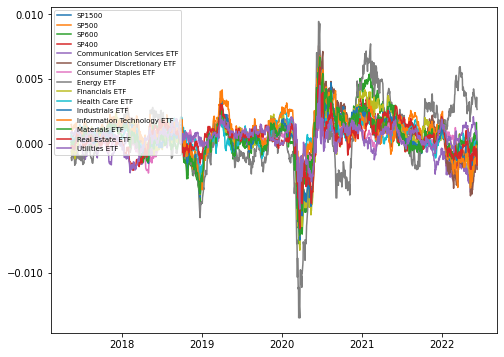

In [216]:
print("Rolling Quarterly Mean Return")
plt.plot(sector_performance_Q_smoothed_return)
plt.legend([*[i for i in spdr_indexes.index],*[v for v in vanguard_sectors.index]],loc=2,fontsize=7)
plt.show()

Quarterly Returns


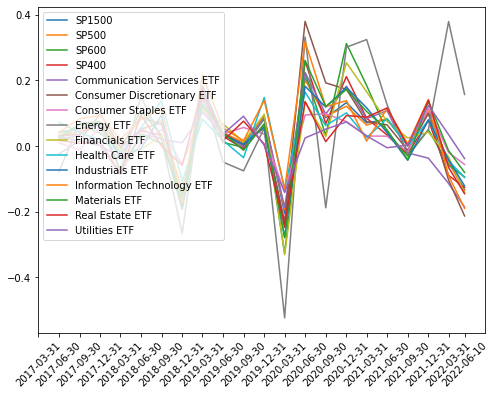

In [217]:
print ("Quarterly Returns")
for v in sector_performance_return.T.index:
    subset = pd.DataFrame(sector_performance_return.T.loc[v])
    subset.columns = ['Return']
    plt.plot(subset)
    plt.xticks(subset.index, rotation=45)
plt.legend(sector_performance_return.T.index,loc=2)    
plt.show()


In [218]:
#sector_performance_return.iloc[-1].sort_values(ascending=False).index

In [219]:
#sector_performance_return

In [220]:
#seasonal_indexes.index

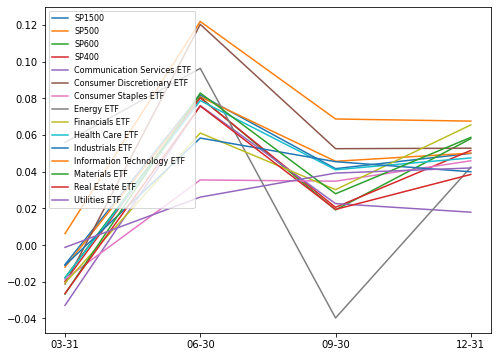

In [221]:
plt.plot(seasonal_indexes[si].T)
plt.legend(seasonal_indexes[si].T.columns,loc=2,fontsize=8)
plt.show()

In [222]:
#seasonal_indexes[seasonal_indexes.columns.difference(si)]

In [223]:
threshold = .975

In [224]:
screener_sorted_ = screener_sorted.reset_index().merge(stock_indexes,on='Symbol',how='left')


screener_good = screener_sorted_[screener_sorted_['risk_trend_factor']!='missing']

risk_trend_threshold = screener_good['risk_trend_factor'].quantile(q=[threshold]).values[0]


In [225]:
risk_trend_threshold

2.2634783422537827

In [226]:
stock_sectors = stock_fundamentals['sector']

In [227]:
temp = stock_sectors.reset_index()
temp.columns = ['Symbol','Sector']
sector_merged = screener[['risk_trend_factor']].merge(temp, on='Symbol', how='right')
temp_sm = sector_merged.merge(sp1500_index_df, on='Symbol', how='left').set_index('Symbol')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index']
temp_sm = temp_sm.merge(spdr_indexes.reset_index(), on='index', how='left')
temp_sm.columns = ['risk_trend_factor', 'Sector', 'index','index_Symbol']
temp_sm.index = sector_merged['Symbol']

for spdr_ in range(0,len(spdr_indexes['Symbol'].values)):
    spdr__ = spdr_indexes['Symbol'].values[spdr_]
    #print(spdr__)
    spdr__i = spdr_indexes['Symbol'].index[spdr_]
    #print(spdr__i)
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index']] = spdr__i
    temp_sm.iloc[np.where(temp_sm.index==spdr__)][['index_Symbol']] = spdr__
    #print()
    
#temp_sm
#temp

array([[<AxesSubplot:title={'center':'risk_trend_factor'}>]], dtype=object)

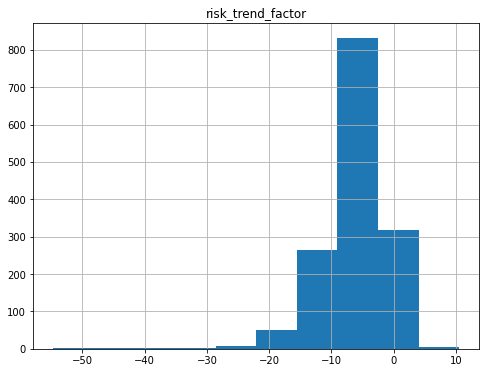

In [228]:
screener[['risk_trend_factor']].replace(['missing','error'], np.NaN).dropna().hist()

In [229]:
len(screener)

1530

In [230]:
risk_screened = screener_good[(screener_good['risk_trend_factor']>risk_trend_threshold) & (screener_good['volume_factor']!= 'missing')]
risk_screened = risk_screened.merge(temp, on='Symbol', how='left')
print(risk_screened.columns)
display(risk_screened[['Symbol','latest_p','risk_trend_factor','adf','hurst','Sector','Market Index','vol_30d_2yr']])
#left join sector
#risk_screened[['risk_trend_factor']].dropna().hist()

Index(['Symbol', 'max_2y', 'min_2y', 'std_2y', 'mean_2y', 'max_1y', 'min_1y',
       'std_1y', 'mean_1y', 'latest_p', '2yr_close_0pct', '2yr_close_2pct',
       '2yr_close_9pct', '2yr_close_25pct', '2yr_close_50pct',
       '2yr_close_75pct', '2yr_close_91pct', '2yr_close_98pct',
       '2yr_close_100pct', '1yr_close_0pct', '1yr_close_2pct',
       '1yr_close_9pct', '1yr_close_25pct', '1yr_close_50pct',
       '2yr_close_75pct', '1yr_close_91pct', '1yr_close_98pct',
       '1yr_close_100pct', 'risk_trend_factor', 'supply_trend_1yr',
       'supply_trend_180d', 'supply_trend_90d', 'supply_trend_60d',
       'supply_trend_30d', 'vol_30d_2yr', 'pct_1yr', 'pct_2yr',
       'MIN_Lookback_One_Year', 'MIN_Lookback_6_Months',
       'MIN_Lookback_2_Months', 'MIN_Lookback_1_Months', 'volume_factor',
       'adf', 'hurst', 'Market Index', 'Sector'],
      dtype='object')


Symbol    latest_p risk_trend_factor       adf     hurst  \
0    MTOR   36.119999         10.517268  0.308552  0.433895   
1       Y  834.109985          7.384772  0.389055  0.457411   
2    TVTY   32.279999           5.39315  0.524133  0.449983   
3     MCK  313.339996          4.004949  0.998714  0.463166   
4     ACC   64.769997          3.917188  0.981927  0.416828   
5     CVX  175.399994          3.856637   0.97985  0.498334   
6     EQT   47.959999          3.747308  0.932879  0.501911   
7    LNTH   63.849998          3.540933  0.990883  0.532857   
8     SWX   91.889999          3.530074  0.284442  0.398907   
9     MPC  108.339996          3.513423  0.991702  0.523957   
10   MUSA  237.960007           3.50354   0.99617  0.410367   
11    SJI   34.060001          3.390476  0.165217  0.413386   
12    VDE  123.860001          3.378308  0.947803   0.52196   
13    XOM  100.459999          3.314307  0.977852  0.536671   
14    DVN   74.059998          3.254185  0.994381  0.555599   
15    MRO   30.290001          3.229066  0.972772   0.54597   
16    PBF   40.330002          3.225693  0.730477  0.555776   
17    APA   48.810001          3.199621  0.443494   0.44772   
18   CTRA   34.310001          3.192947  0.507048  0.467954   
19    COP  116.830002          3.181252  0.992942  0.491541   
20    VLO  140.509995          3.155888  0.970961  0.536721   
21    EOG       144.0          3.013262  0.922673  0.487021   
22    WRB   68.260002          2.908126  0.965152  0.455795   
23    HES  127.720001           2.88093   0.97499  0.449233   
24   CEIX       52.91          2.853516  0.933936  0.522101   
25   FANG  155.490005          2.734463  0.837164  0.472651   
26   CIVI   80.660004          2.668131  0.020246   0.49614   
27    NFG   72.650002          2.655036  0.982328  0.468009   
28   PDCE   84.129997          2.633596   0.76826  0.495944   
29    OXY   63.869999          2.620612  0.777852  0.546207   
30    PXD  270.869995          2.603258  0.935146  0.498349   
31    CNX       23.24          2.576298  0.784231  0.406859   
32   MTDR   65.230003          2.551954  0.987482   0.46805   
33   DINO   56.369999          2.525424  0.412505  0.562704   
34    HRB   35.450001          2.371017  0.838883   0.43511   
35    MUR   44.150002          2.319887  0.869435  0.455651   
36     SM   50.560001          2.268271  0.976245  0.479096   
37    RRC   34.439999          2.265651  0.784588  0.495379   

                Sector Market Index       vol_30d_2yr  
0                error        SP600    20301256.12708  
1   Financial Services        SP400    1456858.698941  
2                error        SP600   14974563.993949  
3           Healthcare        SP500   33946622.768533  
4                error        SP400   20837020.877458  
5               Energy        SP500  181490743.721634  
6               Energy        SP400  137472571.699697  
7           Healthcare        SP600   10889615.279879  
8            Utilities        SP400    7059509.304085  
9               Energy        SP500  132481329.198185  
10   Consumer Cyclical        SP400    7365132.299546  
11           Utilities        SP600   18167782.072617  
12               error          NaN   15894021.482602  
13              Energy        SP500  399482859.531014  
14              Energy        SP500  181231964.523449  
15              Energy        SP500  385905130.635401  
16              Energy        SP600   65359710.136157  
17              Energy        SP500  154170566.944024  
18              Energy        SP500  150668871.709531  
19              Energy        SP500  164910706.505295  
20              Energy        SP500   84050366.565809  
21              Energy        SP500   86714140.166415  
22  Financial Services        SP500    23023001.53177  
23              Energy        SP500   66701550.453858  
24              Energy        SP600     9591390.71618  
25              Energy        SP500   49440914.674735  
26              Energy        SP6

In [231]:
#screener.columns

In [232]:
"""
above_1yearSDev = screener_good[screener_good['latest_p']>screener['mean_1y']+screener_good['std_1y']]['Symbol'].values
above_2yearSDev = screener_good[screener_good['latest_p']>screener['mean_2y']+screener_good['std_2y']]['Symbol'].values
above_yearSDev = np.intersect1d(above_1yearSDev,above_2yearSDev)
"""

"\nabove_1yearSDev = screener_good[screener_good['latest_p']>screener['mean_1y']+screener_good['std_1y']]['Symbol'].values\nabove_2yearSDev = screener_good[screener_good['latest_p']>screener['mean_2y']+screener_good['std_2y']]['Symbol'].values\nabove_yearSDev = np.intersect1d(above_1yearSDev,above_2yearSDev)\n"

In [233]:
#above_yearSDev

In [234]:
"""
above_2year_t = screener[screener['pct_2yr']>threshold]['Symbol'].values
above_1year_t = screener[screener['pct_1yr']>threshold]['Symbol'].values
above_years_t = np.intersect1d(above_2year_t,above_1year_t)
"""

"\nabove_2year_t = screener[screener['pct_2yr']>threshold]['Symbol'].values\nabove_1year_t = screener[screener['pct_1yr']>threshold]['Symbol'].values\nabove_years_t = np.intersect1d(above_2year_t,above_1year_t)\n"

In [235]:
#screened_final_set = risk_screened.set_index('Symbol')
#screened_final_set
screened_final_set = risk_screened

In [236]:
import pickle
fundamentals_quarterlies = pickle.load(open('./fundamental.pkl', 'rb'))

In [237]:
fundamental_entries = [e[0] for e in fundamentals_quarterlies]

In [238]:
list_ = []
for i in index_risk_sorted['Symbol'].values:
    list_.append(i)
for i in sectors_risk_sorted['Symbol'].values:
    list_.append(i)
for i in screened_final_set['Symbol'].values:
    list_.append(i)
indexes = np.unique(list_, return_index=True)[1]
list__ = [list_[index] for index in sorted(indexes)]

In [239]:
#np.unique(stock_sectors.values)

In [240]:
dict_sectors = {'Basic Materials':'VAW', 'Communication Services':'VOX', 'Consumer Cyclical':'VCR',
       'Consumer Defensive':'VDC', 'Energy':'VDE', 'Financial Services':'VFH', 'Healthcare':'VHT',
       'Industrials':'VIS', 'Real Estate':'VNQ', 'Technology':'VGT', 'Utilities':'VPU', 'error':'error'}

In [241]:
dict_indexes = {'SPTM':'SP1500', 'SPY':'SP500', 'SLY':'SP600', 'MDYG':'SP400','error':'error'}

In [243]:
dict_sectors_reverse = {'VAW':'Basic Materials',
 'VOX':'Communication Services',
 'VCR':'Consumer Cyclical',
 'VDC':'Consumer Defensive',
 'VDE':'Energy',
 'VFH':'Financial Services',
 'VHT':'Healthcare',
 'VIS':'Industrials',
 'VNQ':'Real Estate',
 'VGT':'Technology',
 'VPU':'Utilities',
 'error': 'error'}

adf < .05 or .01, mean reverting
Hurst
> .5 - The time series is mean reverting.
= .5 - The time series is a Geometric Brownian Motion.
< .5 - The time series is trending.
symbol: SPY
sector: error
sector: error
Index: SP500
supply trend: 1781380150.6807866
risk trend factor: -4.314957039491863
      totalAssets  trailingPE
SPY  3.781762e+11    4.292843


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  389.799988  384.809441  402.729524  420.649606  424.242223   

             90dSDev   90d_lower   90d_upper  
2022-06-10  21.62419  380.993843  467.490604

volume_factor    latest_p        vol_30d_2yr   pct_2yr       adf     hurst
SPY      1.065993  389.799988  1781380150.680787  0.501905  0.730083  0.423507

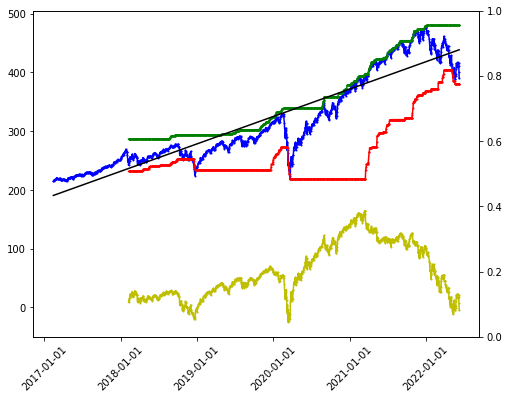

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[602.1488945180929, 7385.024756923199, 636.89746728288, 604.6083590110914]
best model: ets_TT
best score: 602.1488945180929
sell date: 2022-08-28
expected return: 0.07468322706745872


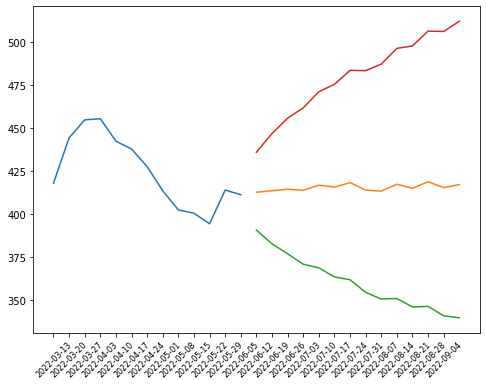

['options', ('2022-06-17', '2022-06-30', '2022-09-16', '2022-09-30', '2022-12-16', '2023-01-20', '2023-03-17', '2023-06-16', '2023-12-15', '2024-01-19', '2024-12-20')]
symbol: SPTM
sector: error
sector: error
Index: SP1500
supply trend: 10701430.030257186
risk trend factor: -4.323113872768143
Empty DataFrame
Columns: []
Index: [SPTM]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10     48.16  47.422277  49.676984  51.931691  52.277778  2.617361   

            90d_lower 90d_upper  
2022-06-10  47.043055   57.5125

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
SPTM      1.445517    48.16  10701430.030257  0.514882  0.731043  0.430862

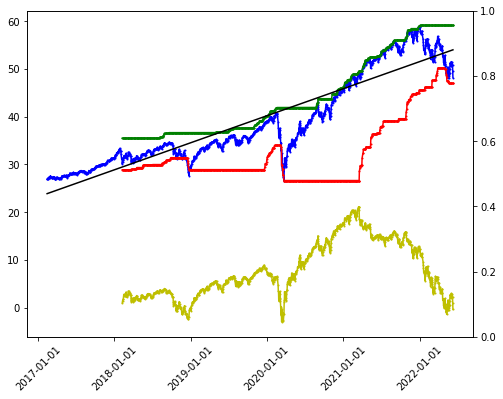

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[9.571990503633371, 118.14799303421566, 10.215045204149614, 9.587800993362691]
best model: ets_TT
best score: 9.571990503633371
sell date: 2022-08-28
expected return: 0.07559633122124303


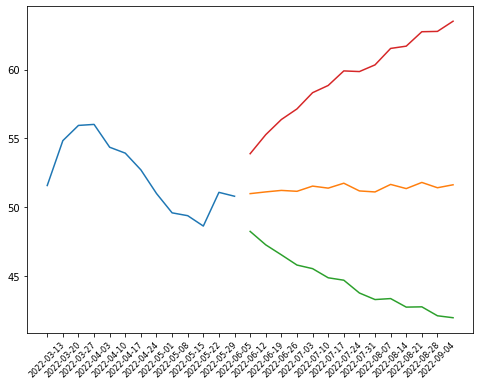

['options', ('2022-06-17',)]
symbol: SLY
sector: error
sector: error
Index: SP600
supply trend: 1733621.860816944
risk trend factor: -5.831832561133962
Empty DataFrame
Columns: []
Index: [SLY]


Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  84.790001  81.56592  86.101746  90.637572  89.273651  3.873503   

            90d_lower  90d_upper  
2022-06-10  81.526645  97.020657

volume_factor   latest_p     vol_30d_2yr  pct_2yr       adf     hurst
SLY      1.265097  84.790001  1733621.860817  0.58507  0.631357  0.516612

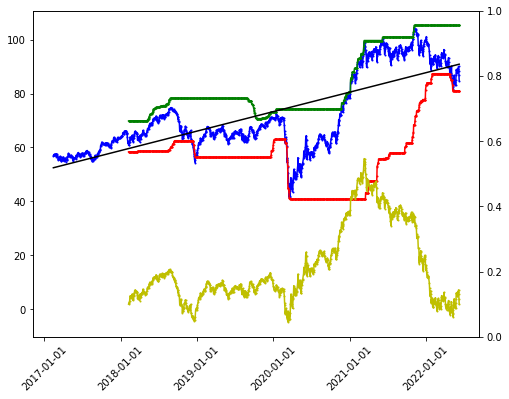

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[58.51683234008597, 1926137.408727314, 62.736521661212045, 58.31760060487062]
best model: ets_FF
best score: 58.31760060487062
sell date: 2022-08-14
expected return: 0.07779854454138108


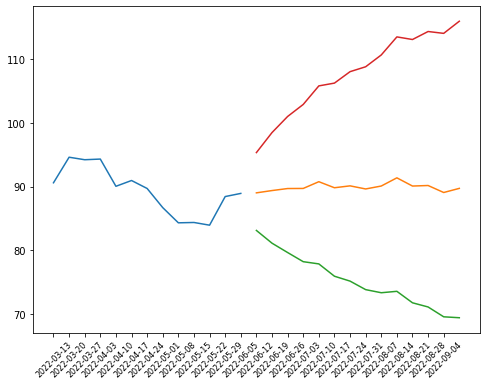

symbol: MDYG
sector: error
sector: error
Index: SP400
supply trend: 3870598.865355522
risk trend factor: -5.932475578582748
Empty DataFrame
Columns: []
Index: [MDYG]


Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  64.839996  62.654627  66.371428  70.088229  69.963968  3.726597   

            90d_lower  90d_upper  
2022-06-10  62.510773  77.417163

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MDYG      0.727588  64.839996  3870598.865356  0.405859  0.564973  0.453632

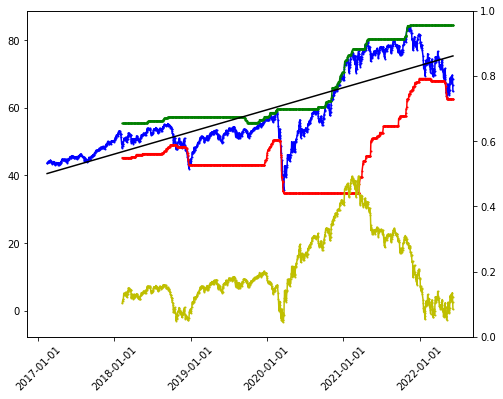

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[23.482187084704588, 296.34586919210926, 26.932091492945688, 23.390902511553485]
best model: ets_FF
best score: 23.390902511553485
sell date: 2022-08-14
expected return: 0.08596664505969231


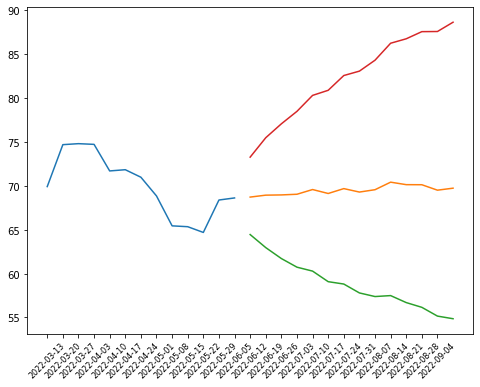

['options', ('2022-06-17',)]
symbol: VDE
sector: error
sector: Energy
Index: nan
supply trend: 15894021.482602118
risk trend factor: 3.3783083383264243
      totalAssets  trailingPE
VDE  1.106882e+10   10.692059


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  123.860001  107.166137  119.294921  131.423705  111.724762   

             90dSDev  90d_lower   90d_upper  
2022-06-10  7.181377  97.362008  126.087517

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf    hurst
VDE      1.169962  123.860001  15894021.482602  0.930759  0.947803  0.52196

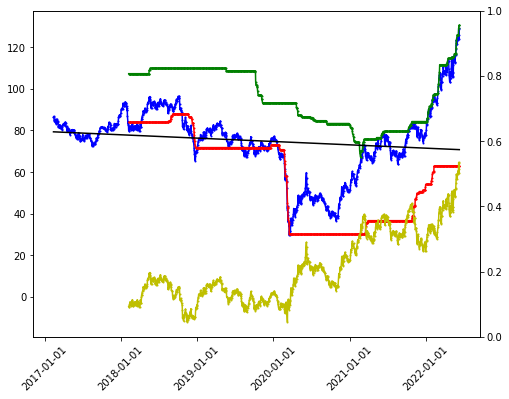

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[161.36209308731404, 778.3056281118837, 161.25127350485565, 161.56935438236346]
best model: ets_TF
best score: 161.25127350485565
sell date: 2022-09-11
expected return: 0.0830558432304938


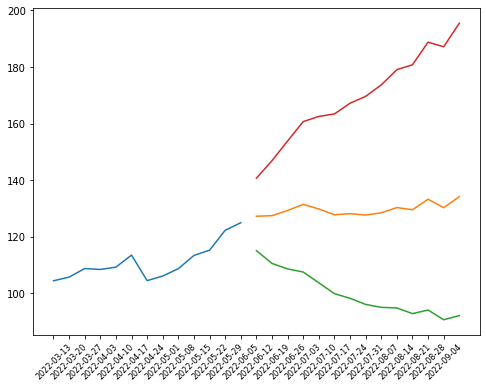

['options', ('2022-06-17',)]
symbol: VPU
sector: error
sector: Utilities
Index: nan
supply trend: 4401008.169440242
risk trend factor: -0.9038459354057021
      totalAssets
VPU  7.799146e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  155.610001  152.644005  158.881905  165.119806  159.366349   

             90dSDev   90d_lower   90d_upper  
2022-06-10  4.141233  151.083883  167.648816

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VPU      1.073413  155.610001  4401008.16944  0.750053  0.731044  0.299247

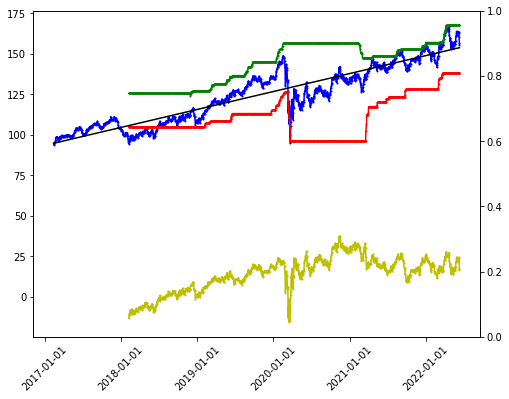

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[171.6964662694464, 1342.9188886419684, 158.16596830858134, 158.18937967342805]
best model: ets_TF
best score: 158.16596830858134
sell date: 2022-06-12
expected return: 0.03581037419957649


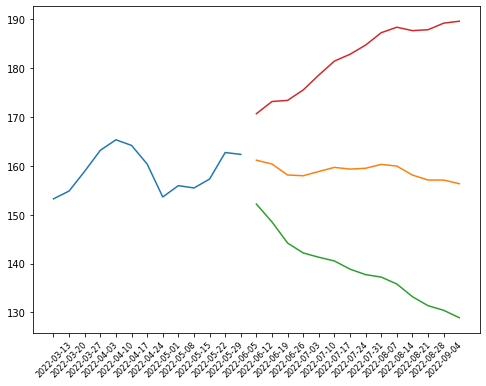

['options', ('2022-06-17',)]
symbol: VDC
sector: error
sector: Consumer Defensive
Index: nan
supply trend: 3239531.5431164904
risk trend factor: -1.81537011564274
      totalAssets
VDC  8.239956e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  184.889999  180.713861  189.626984  198.540108  195.577937   

             90dSDev   90d_lower  90d_upper  
2022-06-10  6.579991  182.417955  208.73792

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VDC      1.521146  184.889999  3239531.543116  0.610012  0.828818  0.357333

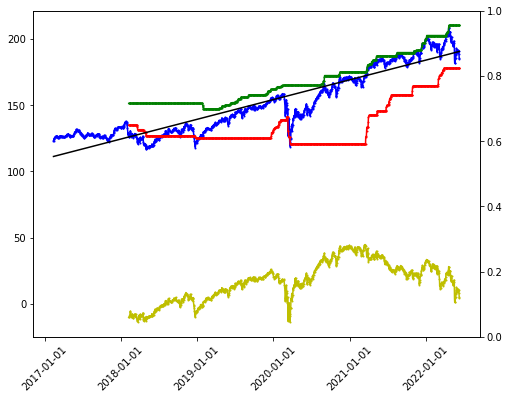

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[91.21850587927463, 805.6385009069012, 92.2058898219544, 91.2268544178318]
best model: ets_TT
best score: 91.21850587927463
sell date: 2022-07-24
expected return: 0.038927988845769194


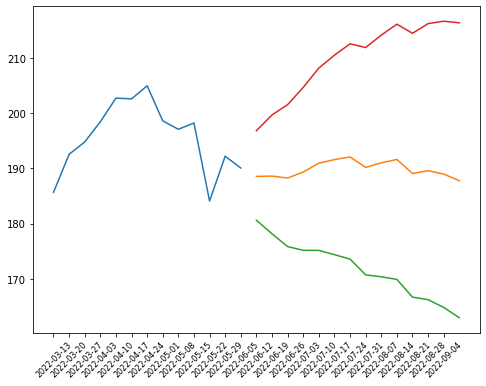

['options', ('2022-07-15',)]
symbol: VAW
sector: error
sector: Basic Materials
Index: nan
supply trend: 2531724.1301059
risk trend factor: -2.9832247911376593
      totalAssets
VAW  5.085875e+09


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  178.449997  175.041332  184.631904  194.222476  188.745238   

             90dSDev   90d_lower   90d_upper  
2022-06-10  6.207227  176.330784  201.159692

volume_factor    latest_p     vol_30d_2yr   pct_2yr     adf     hurst
VAW      1.136419  178.449997  2531724.130106  0.735836  0.8001  0.433204

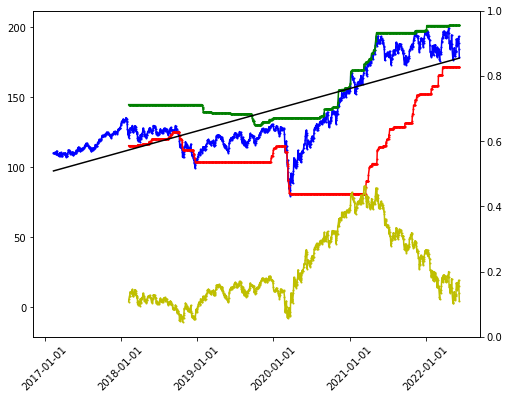

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[168.6545766512616, 1805.2410468947503, 160.66795464408875, 166.81673946036298]
best model: ets_TF
best score: 160.66795464408875
sell date: 2022-08-28
expected return: 0.13208464774083184


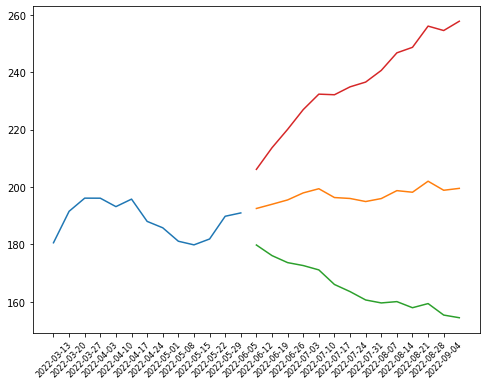

['options', ('2022-08-19',)]
symbol: VNQ
sector: error
sector: Real Estate
Index: nan
supply trend: 111305975.03782149
risk trend factor: -3.885849288582038
      totalAssets
VNQ  7.839537e+10


Adj Close    21dBOLD   21dMA-TP     21dBOLU      90dSMA   90dSDev  \
2022-06-10  92.620003  93.076579  96.729683  100.382786  103.130635  5.926759   

            90d_lower   90d_upper  
2022-06-10  91.277118  114.984153

volume_factor   latest_p       vol_30d_2yr pct_2yr       adf     hurst
VNQ      1.031909  92.620003  111305975.037821   0.416  0.514654  0.397188

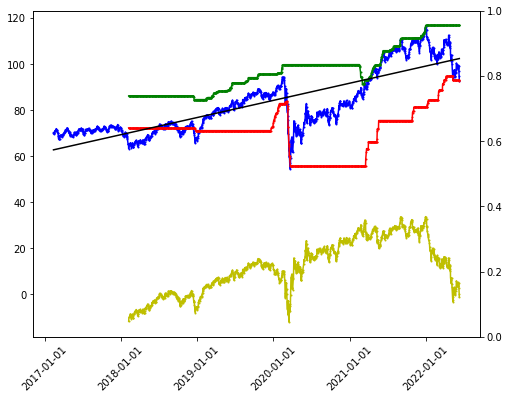

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[82.53508551454624, 1147.7363267013982, 93.25891018346131, 82.17479423667619]
best model: ets_FF
best score: 82.17479423667619
sell date: 2022-07-24
expected return: 0.07018035369427973


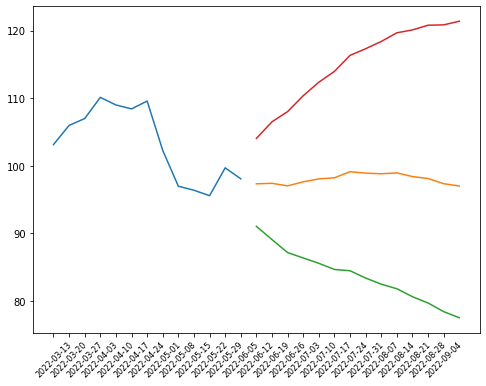

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
symbol: VHT
sector: error
sector: Healthcare
Index: nan
supply trend: 5096065.052950076
risk trend factor: -3.9471429756913072
      totalAssets  trailingPE
VHT  1.944618e+10    5.167231


Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  229.929993  231.084711  237.690476  244.296241  245.914285   

            90dSDev   90d_lower   90d_upper  
2022-06-10  9.56314  226.788005  265.040565

volume_factor    latest_p    vol_30d_2yr   pct_2yr       adf     hurst
VHT      0.947476  229.929993  5096065.05295  0.525621  0.693779  0.333477

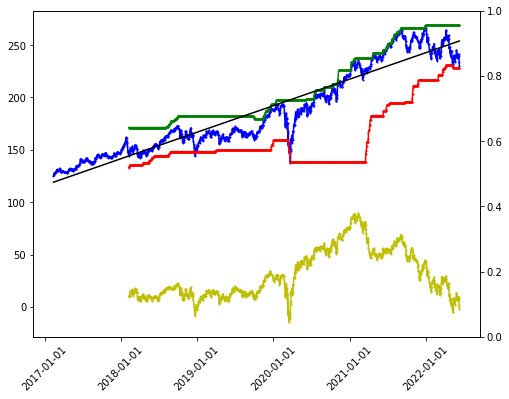

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[99.56405605406994, 1373.0614906469348, 111.67599081073284, 101.92768503259808]
best model: ets_TT
best score: 99.56405605406994
sell date: 2022-08-14
expected return: 0.05378595839721864


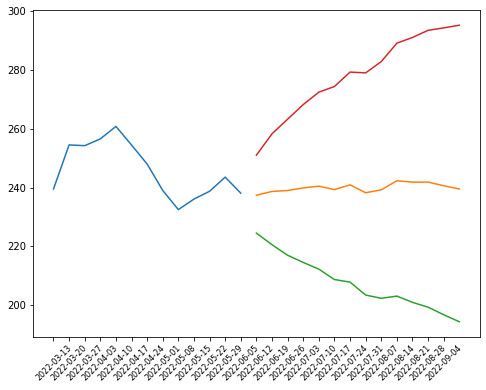

['options', ('2022-06-17',)]
symbol: VIS
sector: error
sector: Industrials
Index: nan
supply trend: 3021835.7791225417
risk trend factor: -5.096829776050351
Empty DataFrame
Columns: []
Index: [VIS]


Adj Close     21dBOLD    21dMA-TP     21dBOLU  90dSMA   90dSDev  \
2022-06-10  170.789993  166.918433  175.029841  183.141249  183.59  8.591236   

             90d_lower   90d_upper  
2022-06-10  166.407528  200.772473

volume_factor    latest_p     vol_30d_2yr  pct_2yr       adf     hurst
VIS      0.897137  170.789993  3021835.779123  0.55486  0.557365  0.472662

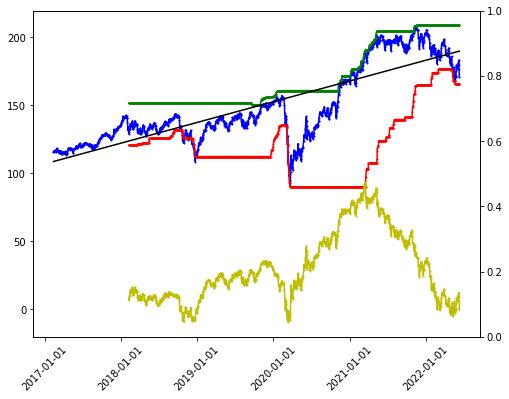

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[250.8373986657273, 2848.218282318593, 248.62559663803532, 251.94388365359814]
best model: ets_TF
best score: 248.62559663803532
sell date: 2022-08-28
expected return: 0.08512505221961984


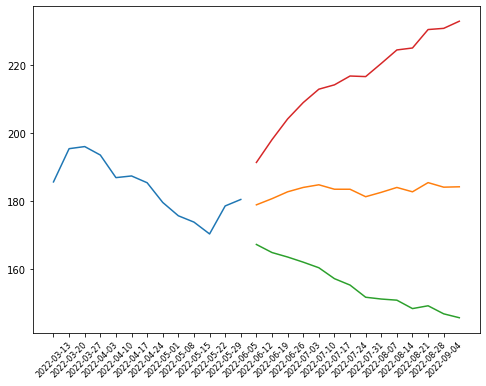

['options', ('2022-08-19',)]
symbol: VCR
sector: error
sector: Consumer Cyclical
Index: nan
supply trend: 2149496.8229954615
risk trend factor: -5.274842912889847
      totalAssets
VCR  6.015592e+09


Adj Close     21dBOLD    21dMA-TP   21dBOLU      90dSMA  \
2022-06-10  240.179993  228.960223  247.434761  265.9093  276.036349   

             90dSDev   90d_lower   90d_upper  
2022-06-10  25.54683  224.942689  327.130008

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VCR       1.24671  240.179993  2149496.822995  0.290163  0.672666  0.471633

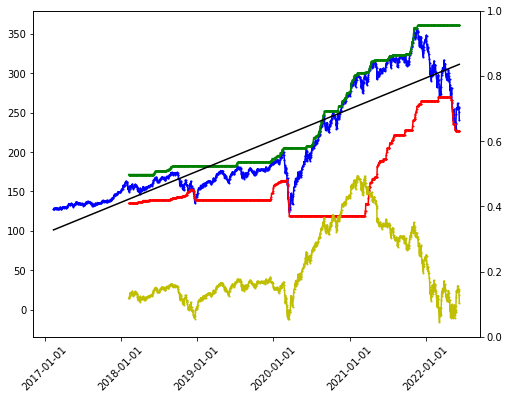

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[352.39542042924086, 5724.394366481684, 362.80882413397677, 357.60776530296005]
best model: ets_TT
best score: 352.39542042924086
sell date: 2022-07-24
expected return: 0.10903811991356427


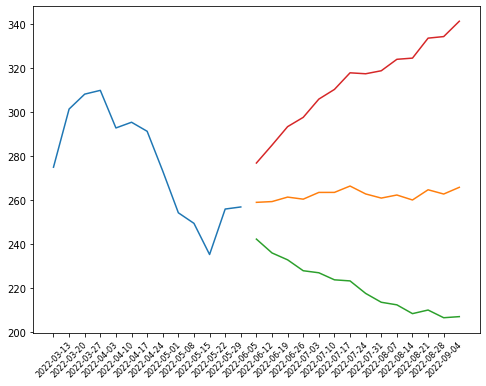

['options', ('2022-06-17',)]
symbol: VFH
sector: error
sector: Financial Services
Index: nan
supply trend: 15854911.649016641
risk trend factor: -5.669686524892829
      totalAssets
VFH  1.055284e+10


Adj Close    21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-10     79.93  79.139405  83.671588  88.203771  88.13127  4.903389   

            90d_lower  90d_upper  
2022-06-10  78.324492  97.938048

volume_factor latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VFH      1.068786    79.93  15854911.649017  0.524221  0.532803  0.492594

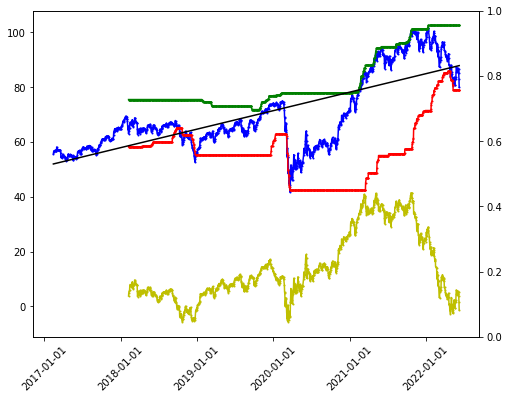

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[80.07008138839834, 589.9949493664573, 83.67449717551786, 79.12923038453297]
best model: ets_FF
best score: 79.12923038453297
sell date: 2022-08-28
expected return: 0.06931764158443161


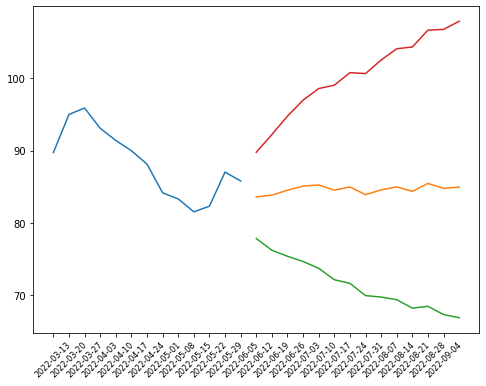

['options', ('2022-08-19',)]
symbol: VGT
sector: error
sector: Technology
Index: nan
supply trend: 13900429.727685325
risk trend factor: -6.117689136620628
      totalAssets
VGT  5.044675e+10


Adj Close     21dBOLD   21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  337.339996  330.411387  350.71381  371.016232  377.021272   

              90dSDev   90d_lower   90d_upper  
2022-06-10  26.470697  324.079878  429.962665

volume_factor    latest_p      vol_30d_2yr pct_2yr       adf     hurst
VGT       1.13554  337.339996  13900429.727685  0.3501  0.739205  0.427823

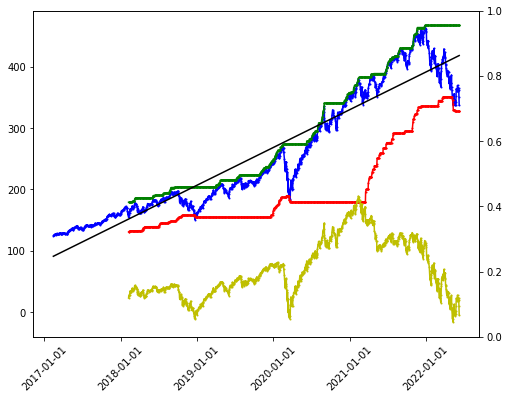

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[392.33439454980504, 8896.658452790549, 537.112271547861, 397.5254615589777]
best model: ets_TT
best score: 392.33439454980504
sell date: 2022-07-24
expected return: 0.09931793133060811


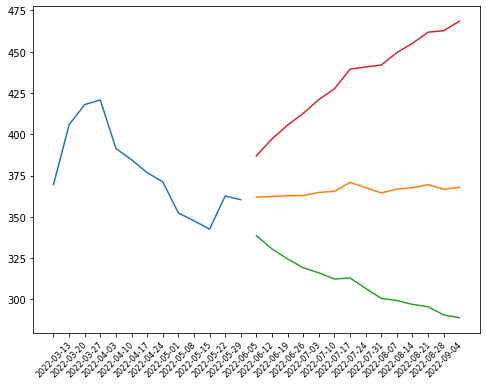

['options', ('2022-06-17', '2022-08-19')]
symbol: VOX
sector: error
sector: Communication Services
Index: nan
supply trend: 4281925.491679274
risk trend factor: -9.183162170232858
Empty DataFrame
Columns: []
Index: [VOX]


Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  97.699997  97.197858  101.223333  105.248808  109.186032   

             90dSDev  90d_lower   90d_upper  
2022-06-10  8.472157  92.241718  126.130346

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
VOX      1.950828  97.699997  4281925.491679  0.137637  0.718884  0.512033

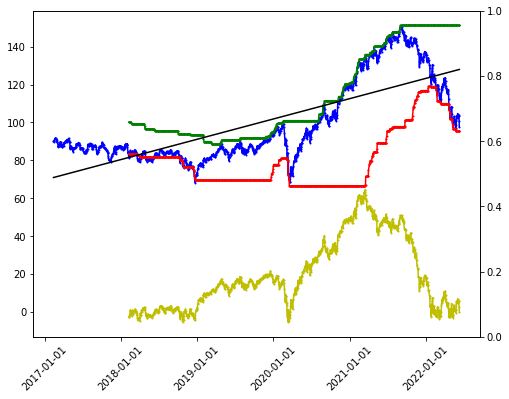

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[57.725808223268146, 637.9639663587576, 55.476697359499084, 57.628848829988144]
best model: ets_TF
best score: 55.476697359499084
sell date: 2022-09-11
expected return: 0.07777845584099354


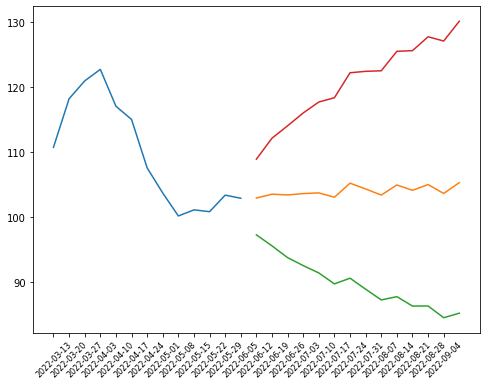

['options', ('2022-07-15',)]
symbol: MTOR
sector: error
sector: error
Index: SP600
supply trend: 20301256.12708018
risk trend factor: 10.517268141249515
Empty DataFrame
Columns: []
Index: [MTOR]


Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-10  36.119999  35.91395  36.090158  36.266367  35.849206  0.25859   

            90d_lower  90d_upper  
2022-06-10  35.332026  36.366386

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
MTOR      1.167952  36.119999  20301256.12708  0.990077  0.308552  0.433895

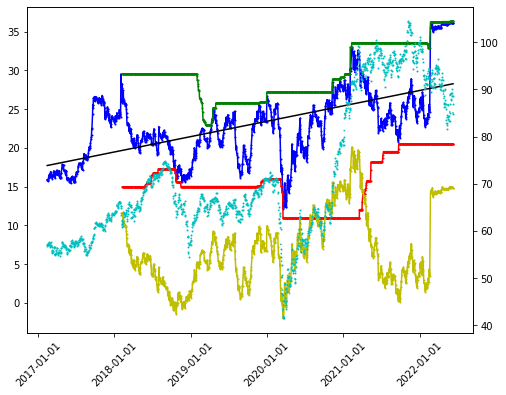

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[37.088917487285904, 138.02310103404474, 37.011981753642054, 37.0807179745845]
best model: ets_TF
best score: 37.011981753642054
sell date: 2022-08-28
expected return: 0.049096775803003645


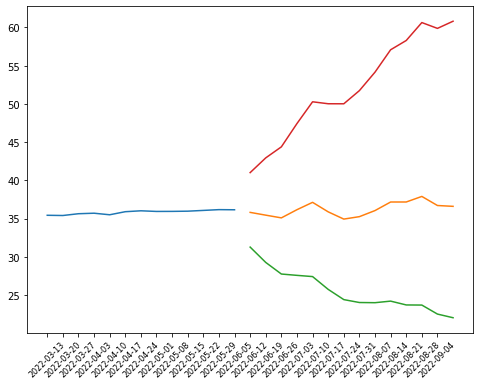

['options', ('2022-08-19',)]
symbol: Y
sector: Financial Services
Index: SP400
supply trend: 1456858.6989409984
risk trend factor: 7.384771627869685
       beta currentRatio debtToEquity earningsGrowth      ebitda  \
Y  0.663839        1.597         31.5         -0.433  1620000000   

  ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
Y       0.13423  9.936376     90016496      0.44211   5101669000   

  heldPercentInstitutions                       industry    marketCap  \
Y                 0.86723  Insurance—Property & Casualty  11220848640   

  operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
Y        1928840960          0.11935           0     0.15    1.305451   

  priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
Y                     0.929715        0.0771      1.004        0.02938   

  returnOnEquity revenueGrowth revenuePerShare              sector  \
Y        0.11868         0.025         878.577  Financial Servic

Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  834.109985  831.51432  833.616982  835.719644  825.774444   

              90dSDev   90d_lower   90d_upper  
2022-06-10  46.881434  732.011576  919.537313

volume_factor    latest_p     vol_30d_2yr   pct_2yr       adf     hurst
Y      1.713893  834.109985  1456858.698941  0.928509  0.389055  0.457411

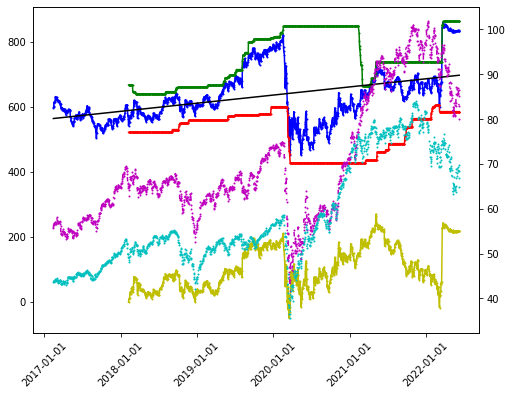

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[11125.902059119768, 54850.16533217167, 11137.771822711953, 11121.889333330679]
best model: ets_FF
best score: 11121.889333330679
sell date: 2022-08-07
expected return: 0.003895652229760672


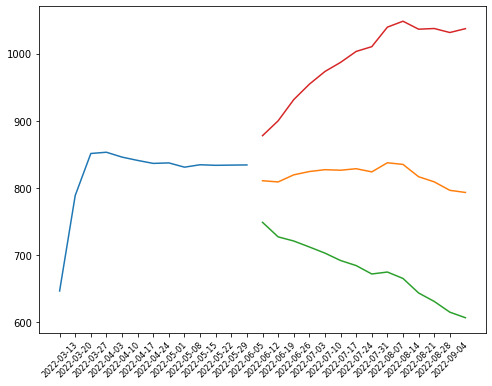

['options', ('2022-07-15',)]
['sustainability',                            Value
2022-5                          
palmOil                    False
controversialWeapons       False
gambling                   False
socialScore                 8.71
nuclear                    False
furLeather                 False
alcoholic                  False
gmo                        False
catholic                   False
socialPercentile            None
peerCount                     96
governanceScore            11.77
environmentPercentile       None
animalTesting              False
tobacco                    False
totalEsg                   21.71
highestControversy             1
esgPerformance          AVG_PERF
coal                       False
pesticides                 False
adult                      False
percentile                 30.32
peerGroup              Insurance
smallArms                  False
environmentScore            1.23
governancePercentile        None
militaryContract           F

Adj Close    21dBOLD   21dMA-TP   21dBOLU     90dSMA   90dSDev  \
2022-06-10  32.279999  31.743907  32.163968  32.58403  31.682698  1.007618   

            90d_lower  90d_upper  
2022-06-10  29.667462  33.697934

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
TVTY      0.975728  32.279999  14974563.993949  0.973128  0.524133  0.449983

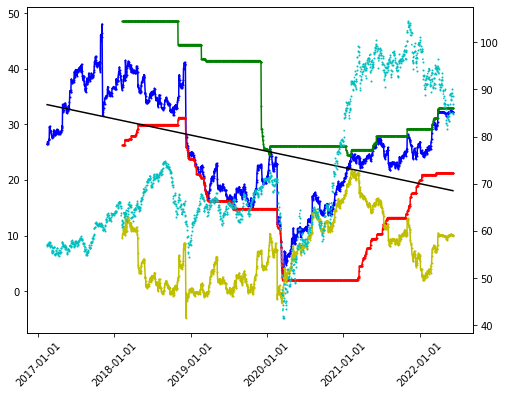

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[43.76767503201743, 161.6383272102374, 42.91633867155539, 43.76004091293027]
best model: ets_TF
best score: 42.91633867155539
sell date: 2022-08-07
expected return: 0.08078147132201667


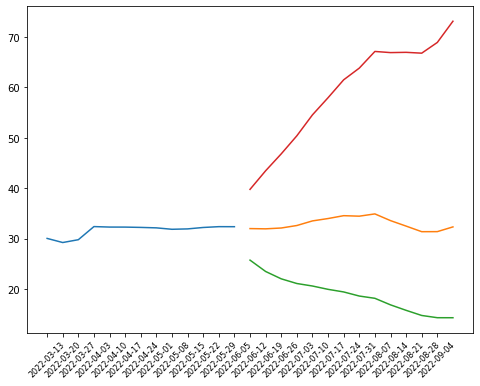

['options', ('2022-08-19',)]
symbol: MCK
sector: Healthcare
Index: SP500
supply trend: 33946622.76853253
risk trend factor: 4.004949352728542
         beta currentRatio dividendRate dividendYield earningsGrowth  \
MCK  0.663839        0.954         1.88        0.0059         -0.406   

         ebitda ebitdaMargins  forwardPE freeCashflow grossMargins  \
MCK  3191000064       0.01209  12.411926   2685625088      0.04957   

    grossProfits heldPercentInstitutions              industry    marketCap  \
MCK  13084000000                  0.9152  Medical Distribution  45990576128   

    operatingCashflow operatingMargins payoutRatio pegRatio  \
MCK        4433999872          0.00965      0.2521        1   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MCK                     0.174229       0.00422      0.456        0.02481   

    revenueGrowth revenuePerShare      sector sharesOutstanding shortRatio  \
MCK         0.118        1733.198  Healthcare         1

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  313.339996  310.325661  323.309364  336.293067  316.762698   

              90dSDev   90d_lower   90d_upper  
2022-06-10  11.943256  292.876186  340.649211

volume_factor    latest_p      vol_30d_2yr  pct_2yr       adf     hurst
MCK      0.653279  313.339996  33946622.768533  0.86712  0.998714  0.463166

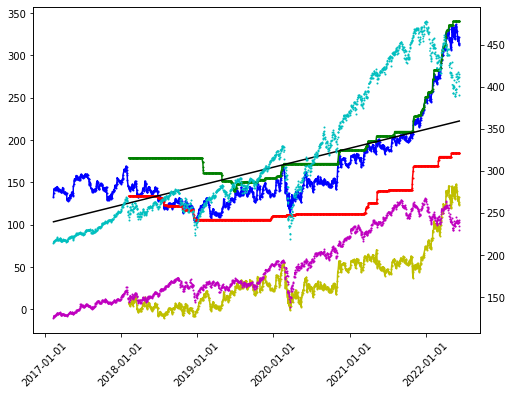

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[493.2253773756614, 1275.6180870733695, 490.3806963232278, 494.16359397922645]
best model: ets_TF
best score: 490.3806963232278
sell date: 2022-09-04
expected return: 0.10031422704427996


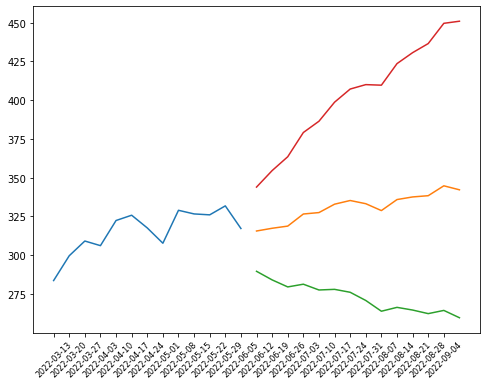

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                             Value
2022-5                           
palmOil                     False
controversialWeapons        False
gambling                    False
socialScore                  7.37
nuclear                     False
furLeather                  False
alcoholic                   False
gmo                         False
catholic                    False
socialPercentile             None
peerCount                      58
governanceScore              5.52
environmentPercentile        None
animalTesting               False
tobacco                     False
totalEsg                    15.17
highestControversy              3
esgPerformance         UNDER_PERF
coal                        False
pesticides                  False
adult                       False
percentile                  10.18
peerGroup              Healthcare
smallArms                   False
environmentScore             2.29
governa

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-10  64.769997  64.467277  64.776825  65.086373  61.316984  4.33668   

            90d_lower  90d_upper  
2022-06-10  52.643624  69.990344

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
ACC      2.984429  64.769997  20837020.877458  0.986823  0.981927  0.416828

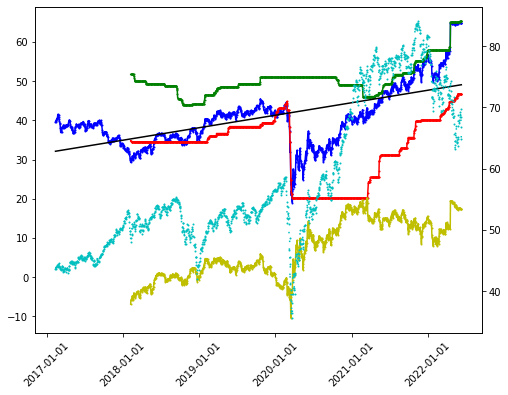

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[42.17915193657419, 250.0350405606479, 51.923755243485175, 42.14536865064987]
best model: ets_FF
best score: 42.14536865064987
sell date: 2022-07-17
expected return: 0.008860845391972164


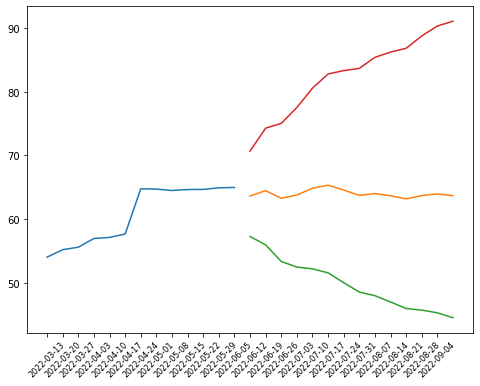

['options', ('2022-06-17',)]
symbol: CVX
sector: Energy
Index: SP500
supply trend: 181490743.72163388
risk trend factor: 3.856636911038389
         beta currentRatio debtToEquity dividendRate dividendYield  \
CVX  1.078947        1.433       19.941         5.68        0.0315   

    earningsGrowth       ebitda ebitdaMargins  forwardPE freeCashflow  \
CVX          3.473  38521999360       0.21783  12.431709  21073375232   

    grossMargins grossProfits heldPercentInstitutions              industry  \
CVX      0.40935  66234000000                 0.71587  Oil & Gas Integrated   

        marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
CVX  355886039040       33045999616          0.12219      0.5113      0.6   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
CVX    2.433922                     2.012429       0.11596      1.119   

    returnOnAssets returnOnEquity revenueGrowth revenuePerShare  sector  \
CVX        0.05505         0.1469    

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-10  175.399994  164.142905  173.680233  183.21756  166.649167   

             90dSDev  90d_lower   90d_upper  
2022-06-10  6.846673  152.95582  180.342513

volume_factor    latest_p       vol_30d_2yr   pct_2yr      adf     hurst
CVX      1.209596  175.399994  181490743.721634  0.940293  0.97985  0.498334

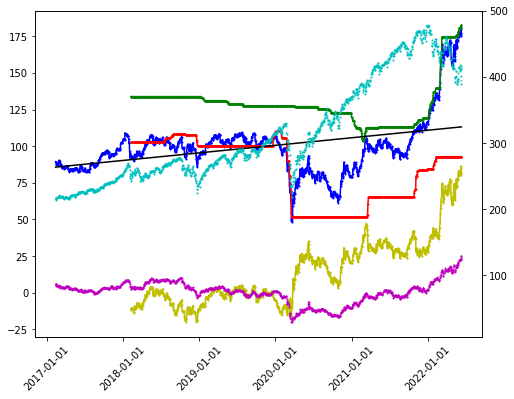

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[270.70996530546466, 985.5540860490764, 270.92498745673464, 264.0577549689023]
best model: ets_FF
best score: 264.0577549689023
sell date: 2022-08-28
expected return: 0.0732219195551491


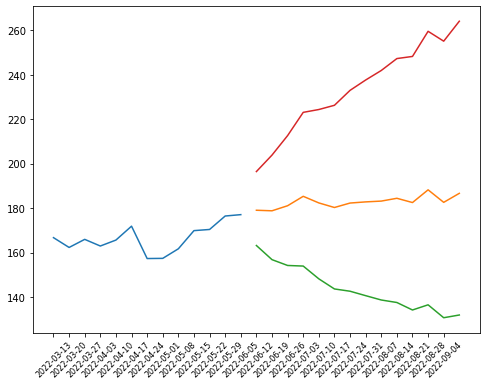

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          10.63
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       9.95
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                                43
highestControversy                       3
esgPerformance                   LEAD_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP   21dBOLU     90dSMA   90dSDev  \
2022-06-10  47.959999  37.159954  45.132857  53.10576  39.467778  6.586657   

            90d_lower  90d_upper  
2022-06-10  26.294463  52.641093

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
EQT      1.217357  47.959999  137472571.699697  0.938581  0.932879  0.501911

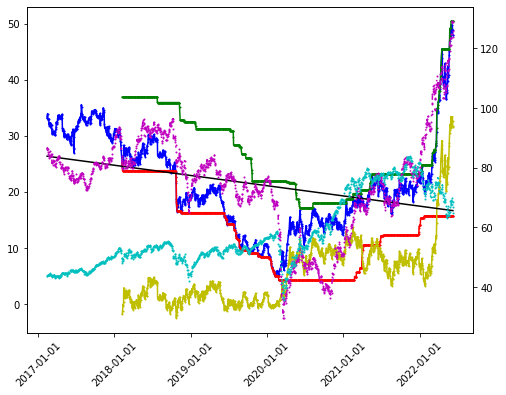

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[28.44991786025738, 5821.922236195096, 29.939445873446793, 27.26944820050287]
best model: ets_FF
best score: 27.26944820050287
sell date: 2022-09-11
expected return: 0.12214109368976739


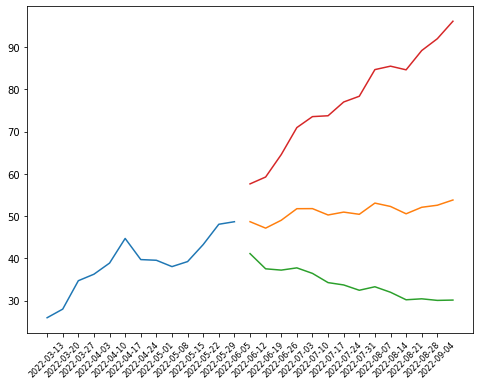

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Total Liab                 1.360858e+10  1.156162e+10  1.475200e+10   
Total Stockholder Equity   8.188673e+09  1.002953e+10  8.248460e+09   
Minority Interest          1.736000e+07  1.623600e+07  1.126500e+07   
Other Current Liab         5.695198e+09  2.471048e+09  6.032718e+09   
Total Assets               2.181461e+10  2.160739e+10  2.301172e+10   
Common Stock               9.921348e+09  1.016796e+10  1.018065e+10   
Other Current Assets       1.304109e+09  6.911100e+08  1.428073e+09   
Retained Earnings         -1.725279e+09 -1.157790e+08 -1.908833e+09   
Other Liab                 1.446828e+09  1.926612e+09  1.346475e+09   
Treasury Stock            -7.396000e+06 -2.265700e+07 -2.335900e+07   
Other Assets               4.927920e+08  8.756020e+08  8.897110e+08   
Cash                       1.691300e+07  1.139630e+08  2.279200e+07   
Total Current Liabilities  7.605287e+09  5.080171

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  63.849998  59.745909  66.695412  73.644916  61.080317  5.710885   

            90d_lower  90d_upper  
2022-06-10  49.658547  72.502087

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
LNTH      2.300963  63.849998  10889615.279879  0.843029  0.990883  0.532857

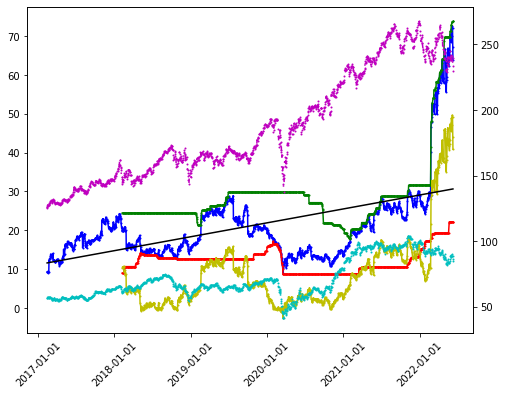

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[131.46162222541506, 191.13249243710652, 124.17771950989888, 131.53178880498288]
best model: ets_TF
best score: 124.17771950989888
sell date: 2022-09-11
expected return: 0.411257268226982


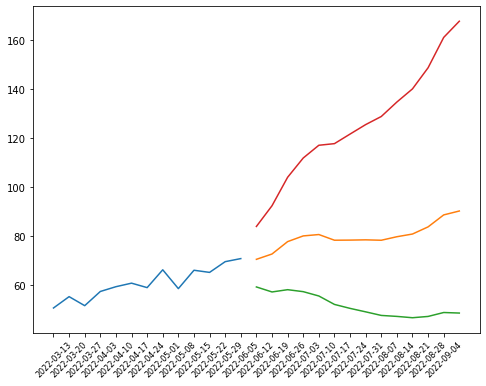

['options', ('2022-07-15',)]
symbol: SWX
sector: Utilities
Index: SP400
supply trend: 7059509.30408472
risk trend factor: 3.5300741485196108
         beta currentRatio debtToEquity dividendRate dividendYield  \
SWX  0.108035        0.778      174.475         2.48        0.0263   

    earningsGrowth     ebitda ebitdaMargins  forwardPE freeCashflow  \
SWX         -0.222  786628992       0.19366  19.052631   -470833120   

    grossMargins grossProfits heldPercentInstitutions  \
SWX      0.21709    853431000                 0.89023   

                    industry   marketCap operatingCashflow operatingMargins  \
SWX  Utilities—Regulated Gas  6292110336         350460000          0.09512   

    payoutRatio pegRatio priceToBook priceToSalesTrailing12Months  \
SWX      0.8123     5.02    1.803307                     1.549036   

    profitMargins quickRatio returnOnAssets returnOnEquity revenueGrowth  \
SWX       0.04423      0.551        0.02178        0.05621         0.431   

    reven

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  91.889999  91.063144  92.741905  94.420666  86.342857  6.301906   

            90d_lower 90d_upper  
2022-06-10  73.739044  98.94667

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
SWX       1.47625  91.889999  7059509.304085  0.903418  0.284442  0.398907

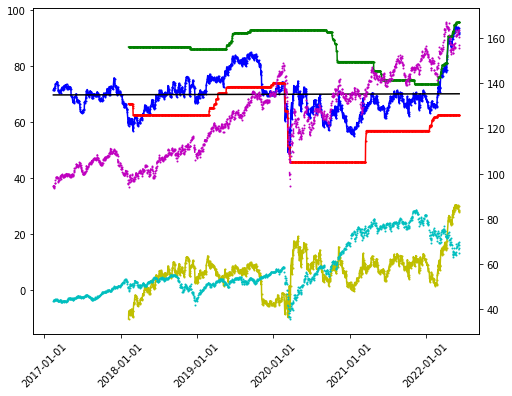

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[68.81703205737814, 280.6531425464983, 76.25075041627917, 68.85980782013527]
best model: ets_TT
best score: 68.81703205737814
sell date: 2022-08-14
expected return: 0.027545572757377436


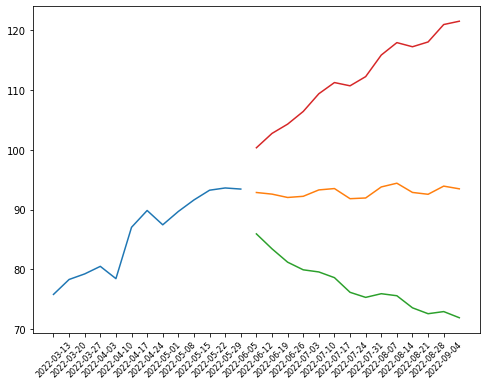

['options', ('2022-07-15',)]
symbol: MPC
sector: Energy
Index: SP500
supply trend: 132481329.19818456
risk trend factor: 3.5134226610249177
         beta currentRatio debtToEquity dividendRate dividendYield  \
MPC  1.910294        1.704       80.117         2.32        0.0242   

    earningsGrowth      ebitda ebitdaMargins  forwardPE freeCashflow  \
MPC          1.917  7120999936       0.05912  25.672987  16415250432   

    grossMargins grossProfits heldPercentInstitutions  \
MPC       0.0867  10443000000                 0.82037   

                           industry    marketCap operatingCashflow  \
MPC  Oil & Gas Refining & Marketing  66692796416        4360000000   

    operatingMargins payoutRatio pegRatio priceToBook  \
MPC          0.03119      0.5472     0.55     2.38288   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MPC                     0.553692       0.08085      1.222        0.02754   

    returnOnEquity revenueGrowth revenuePerShare  

Adj Close    21dBOLD    21dMA-TP     21dBOLU     90dSMA  \
2022-06-10  108.339996  89.236784  101.560094  113.883404  90.742918   

             90dSDev 90d_lower   90d_upper  
2022-06-10  9.631609   71.4797  110.006136

volume_factor    latest_p       vol_30d_2yr   pct_2yr       adf     hurst
MPC      0.997729  108.339996  132481329.198185  0.931541  0.991702  0.523957

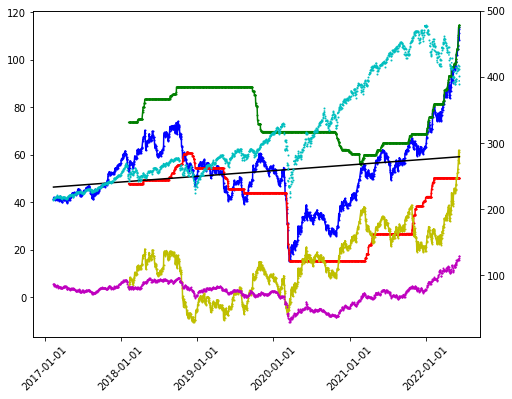

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[108.48902194017911, 3.073168615893619e+30, 104.61900122259222, 109.24308929506898]
best model: ets_TF
best score: 104.61900122259222
sell date: 2022-08-28
expected return: 0.12710086764206754


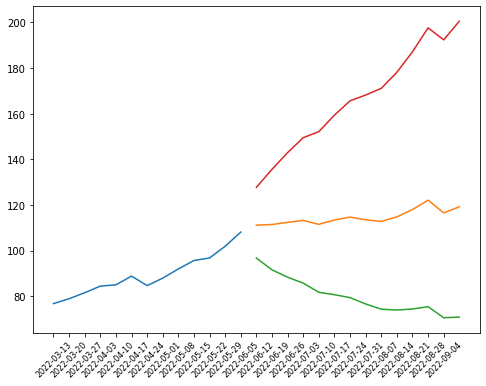

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   3.326200e+10  3.325600e+10  3.323800e+10   
Total Liab                        5.179200e+10  5.333600e+10  5.760700e+10   
Total Stockholder Equity          2.620600e+10  2.828000e+10  2.892100e+10   
Minority Interest                 7.375000e+09  7.684000e+09  7.772000e+09   
Other Current Liab                2.278000e+09  3.377000e+09  6.148000e+09   
Total Assets                      8.537300e+10  8.930000e+10  9.430000e+10   
Common Stock                      1.000000e+07  1.000000e+07  1.000000e+07   
Other Current Assets              5.680000e+08  5.850000e+08  5.850000e+08   
Retained Earnings                 1.290500e+10  1.248400e+10  1.216000e+10   
Other Liab                        7.999000e+09  8.193000e+09  8.825000e+09   
Good Will                         8.256000e+09  8.256000e+09  8.256000e+09   
Treasury Stock                   -1.

Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  237.960007  234.45771  245.340318  256.222926  227.287143   

              90dSDev   90d_lower   90d_upper  
2022-06-10  21.941358  183.404427  271.169859

volume_factor    latest_p     vol_30d_2yr   pct_2yr      adf     hurst
MUSA      1.023661  237.960007  7365132.299546  0.839578  0.99617  0.410367

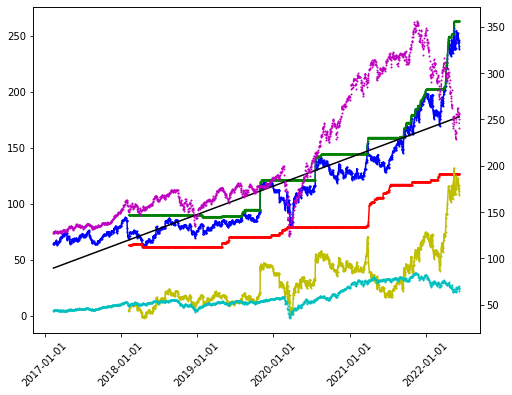

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[230.24089205610974, 731.6731737644211, 223.15596768904987, 230.5362786316883]
best model: ets_TF
best score: 223.15596768904987
sell date: 2022-08-14
expected return: 0.13447557774170577


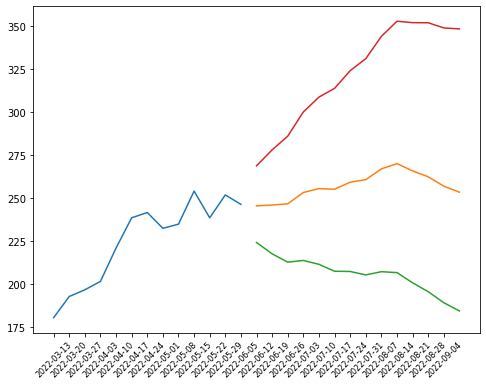

['options', ('2022-07-15', '2022-11-18')]
symbol: SJI
sector: Utilities
Index: SP600
supply trend: 18167782.072617248
risk trend factor: 3.390475619569739
         beta currentRatio debtToEquity dividendRate dividendYield     ebitda  \
SJI  0.767156        0.669      180.745         1.24        0.0371  563539008   

    ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
SJI        0.2829  20.39521   -181286880      0.24213    482333000   

    heldPercentInstitutions               industry   marketCap  \
SJI                 0.85604  Utilities—Diversified  3829979136   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
SJI         273112992          0.17665      1.9758     3.88    2.094454   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
SJI                     1.922684       0.04422      0.438        0.03142   

    returnOnEquity revenuePerShare     sector sharesOutstanding shortRatio  \
SJI        0.04828        

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-10  34.060001  33.346404  34.247778  35.149152  34.300159  0.35026   

            90d_lower  90d_upper  
2022-06-10  33.599639  35.000679

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf     hurst
SJI       1.10309  34.060001  18167782.072617  0.92623  0.165217  0.413386

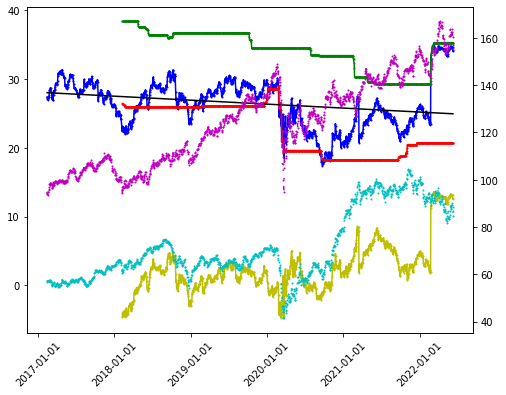

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[21.007337205385713, 59.85103192747266, 21.083260708697292, 20.9907555026607]
best model: ets_FF
best score: 20.9907555026607
sell date: 2022-09-11
expected return: 0.07251061964190578


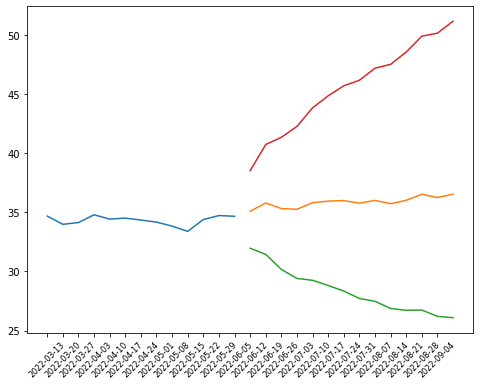

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Intangible Assets          1.404300e+07  1.473100e+07  1.611800e+07   
Capital Surplus            1.559060e+09  1.463655e+09  1.462322e+09   
Total Liab                 5.309231e+09  5.187967e+09  4.938285e+09   
Total Stockholder Equity   1.989152e+09  1.828587e+09  1.887399e+09   
Minority Interest          1.028900e+07  7.457000e+06  7.425000e+06   
Deferred Long Term Liab    6.724160e+08  6.694870e+08  6.701760e+08   
Other Current Liab         1.596050e+08  2.273930e+08  1.760970e+08   
Total Assets               7.308672e+09  7.024011e+09  6.833109e+09   
Common Stock               1.466750e+08  1.405610e+08  1.405570e+08   
Other Current Assets       9.504100e+07  1.416900e+08  8.351100e+07   
Retained Earnings          3.104330e+08  2.628420e+08  3.229880e+08   
Other Liab                 1.141049e+09  1.165851e+09  1.163466e+09   
Good Will                  7.069600e+08  7.069600

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  100.459999  85.804488  95.616984  105.42948  88.303809  6.585828   

            90d_lower   90d_upper  
2022-06-10  75.132152  101.475466

volume_factor    latest_p       vol_30d_2yr   pct_2yr       adf     hurst
XOM      1.434399  100.459999  399482859.531014  0.931373  0.977852  0.536671

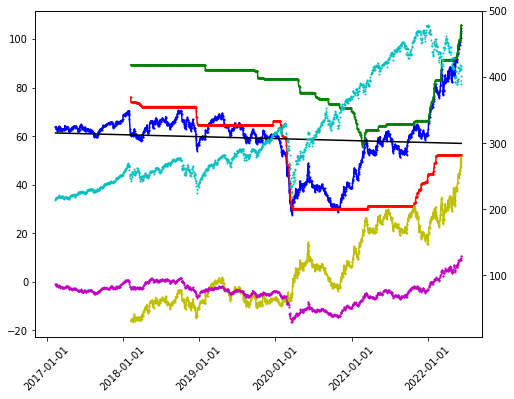

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[63.253257635173604, 467.1029160637048, 62.08632379274023, 63.39092743786638]
best model: ets_TF
best score: 62.08632379274023
sell date: 2022-09-11
expected return: 0.1457590854672255


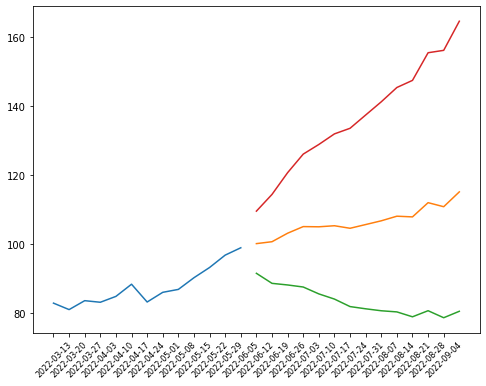

['options', ('2022-06-17', '2022-07-15', '2023-01-20', '2024-01-19', '2026-02-21')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.82
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       8.14
environmentPercentile                 None
animalTesting                         True
tobacco                              False
totalEsg                             36.46
highestControversy                       3
esgPerformance                    OUT_PERF
coal                                 

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  74.059998  65.748411  73.181587  80.614763  64.876349  7.015184   

            90d_lower  90d_upper  
2022-06-10  50.845982  78.906716

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
DVN      1.304951  74.059998  181231964.523449  0.925492  0.994381  0.555599

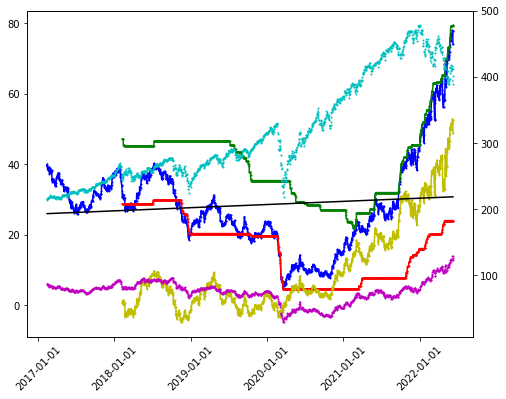

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[59.80766773580759, 376.1595095727094, 60.24345692609078, 60.20060076024578]
best model: ets_TT
best score: 59.80766773580759
sell date: 2022-09-11
expected return: 0.3539976654699068


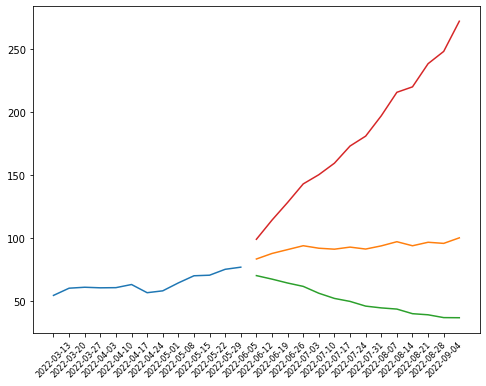

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   7.636000e+09  8.206000e+09  8.189000e+09   
Total Liab                        1.162600e+10  1.199600e+10  1.153000e+10   
Total Stockholder Equity          9.262000e+09  8.924000e+09  8.399000e+09   
Minority Interest                 1.370000e+08  1.370000e+08  1.360000e+08   
Other Current Liab                2.545000e+09  2.940000e+09  2.554000e+09   
Total Assets                      2.102500e+10  2.105700e+10  2.006500e+10   
Common Stock                      6.600000e+07  6.800000e+07  6.800000e+07   
Other Current Assets              5.240000e+08  4.860000e+08  5.030000e+08   
Retained Earnings                 1.692000e+09  7.500000e+08  2.430000e+08   
Other Liab                        1.805000e+09  1.743000e+09  1.698000e+09   
Good Will                         7.530000e+08  7.530000e+08  7.530000e+08   
Treasury Stock                   -1.

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-10  30.290001  25.156063  29.418428  33.680793  26.579703  2.65432   

            90d_lower  90d_upper  
2022-06-10  21.271064  31.888343

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf    hurst
MRO      1.127529  30.290001  385905130.635401  0.900034  0.972772  0.54597

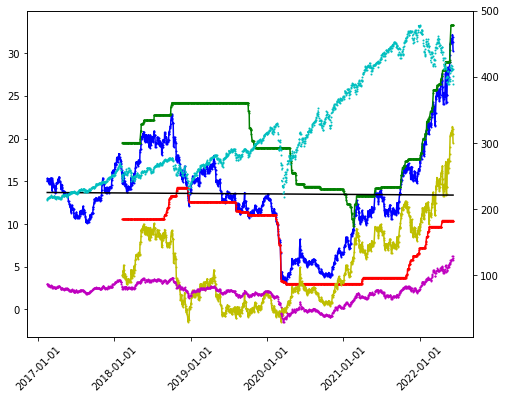

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[15.20151975480824, 48.40803387555796, 16.058338450652858, 16.022323645060546]
best model: ets_TT
best score: 15.20151975480824
sell date: 2022-09-11
expected return: 0.28078658277509094


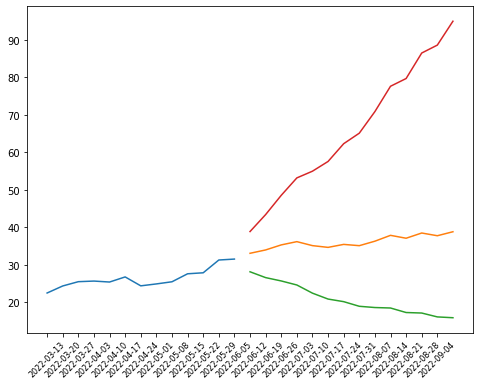

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            7.221000e+09  7.213000e+09  7.201000e+09   
Total Liab                 6.308000e+09  6.365000e+09  7.166000e+09   
Total Stockholder Equity   1.068600e+10  1.079600e+10  1.063400e+10   
Other Current Liab         3.680000e+08  4.960000e+08  5.020000e+08   
Total Assets               1.699400e+10  1.716100e+10  1.780000e+10   
Common Stock               9.370000e+08  9.370000e+08  9.370000e+08   
Other Current Assets       2.200000e+07  2.500000e+07  1.900000e+07   
Retained Earnings          7.271000e+09  6.669000e+09  6.524000e+09   
Other Liab                 6.440000e+08  6.420000e+08  6.650000e+08   
Treasury Stock            -4.743000e+09 -4.023000e+09 -4.028000e+09   
Other Assets               1.100000e+08  1.040000e+08  9.300000e+07   
Cash                       5.800000e+08  4.850000e+08  9.700000e+08   
Total Current Liabilities  1.637000e+09  1.676000

Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-10  40.330002  24.95881  34.143016  43.327222  28.732698  5.47571   

            90d_lower  90d_upper  
2022-06-10  17.781279  39.684118

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PBF      1.018074  40.330002  65359710.136157  0.905392  0.730477  0.555776

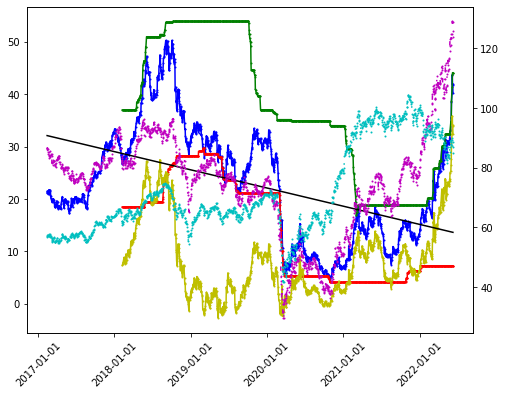

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[82.71731323935032, 282.8635524639607, 104.2538445291788, 81.64657971993337]
best model: ets_FF
best score: 81.64657971993337
sell date: 2022-07-24
expected return: 0.05849371540643158


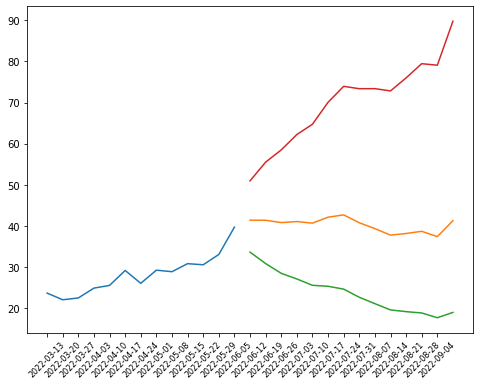

['options', ('2022-06-17', '2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
symbol: APA
sector: Energy
Index: SP500
supply trend: 154170566.9440242
risk trend factor: 3.199620940107091
         beta currentRatio debtToEquity dividendRate dividendYield  \
APA  4.125226        1.227      704.108          0.5        0.0098   

    earningsGrowth      ebitda ebitdaMargins forwardPE freeCashflow  \
APA          4.324  4982000128       0.56569   5.04757   2424875008   

    grossMargins grossProfits heldPercentInstitutions       industry  \
APA      0.67015   5080000000                 0.87511  Oil & Gas E&P   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
APA  16509104128        3716000000          0.40218      0.0339     0.19   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
APA                     1.874543       0.28023      0.882        0.17293   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstandi

Adj Close    21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  48.810001  37.987556  45.39127  52.794983  42.493492  3.486022   

            90d_lower  90d_upper  
2022-06-10  35.521448  49.465537

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf    hurst
APA      1.279846  48.810001  154170566.944024  0.929438  0.443494  0.44772

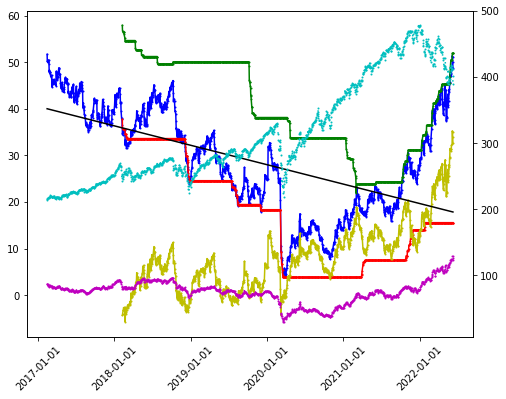

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[65.15731264628403, 293.6984998901142, 64.45272816426568, 65.41853689519317]
best model: ets_TF
best score: 64.45272816426568
sell date: 2022-07-03
expected return: 0.11784037545095911


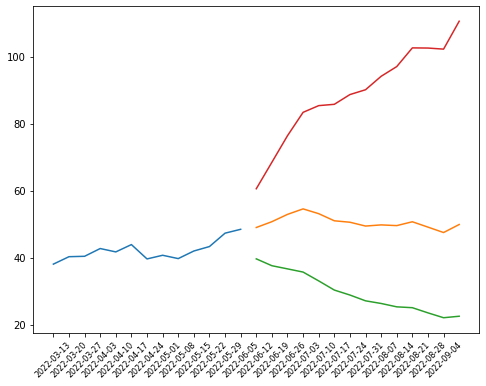

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2021-3                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.88
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               71
governanceScore                       7.96
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             38.81
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  34.310001  28.660914  33.218095  37.775277  29.828254  3.373921   

            90d_lower  90d_upper  
2022-06-10  23.080412  36.576096

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
CTRA      1.337181  34.310001  150668871.709531  0.899416  0.507048  0.467954

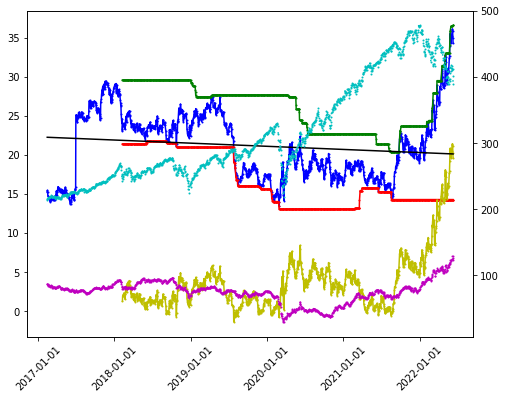

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[8.711369639541406, 48.91766679188906, 11.424325198349157, 8.613656538454695]
best model: ets_FF
best score: 8.613656538454695
sell date: 2022-07-03
expected return: 0.05895663433381905


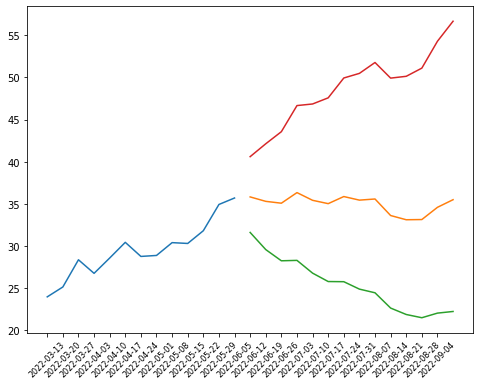

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            1.091100e+10  1.823373e+09  1.815770e+09   
Total Liab                 8.112000e+09  2.404585e+09  2.310672e+09   
Total Stockholder Equity   1.173800e+10  2.326112e+09  2.299895e+09   
Deferred Long Term Liab    5.000000e+06  5.329000e+06  5.844000e+06   
Other Current Liab         1.880000e+08  2.128940e+08  7.719900e+07   
Total Assets               1.990000e+10  4.730697e+09  4.610567e+09   
Common Stock               8.900000e+07  4.786200e+07  4.786200e+07   
Other Current Assets       2.400000e+07  1.323500e+07  1.540000e+07   
Retained Earnings          2.563000e+09  2.276071e+09  2.257320e+09   
Other Liab                 3.512000e+09  9.650310e+08  9.577370e+08   
Treasury Stock            -1.825000e+09 -1.821194e+09 -1.821057e+09   
Other Assets               7.200000e+07  3.109900e+07  3.170800e+07   
Cash                       1.036000e+09  7.627000

Adj Close    21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  116.830002  98.434997  111.473651  124.512305  103.658731   

            90dSDev 90d_lower   90d_upper  
2022-06-10  7.46267  88.73339  118.584071

volume_factor    latest_p       vol_30d_2yr   pct_2yr       adf     hurst
COP      0.946298  116.830002  164910706.505295  0.924909  0.992942  0.491541

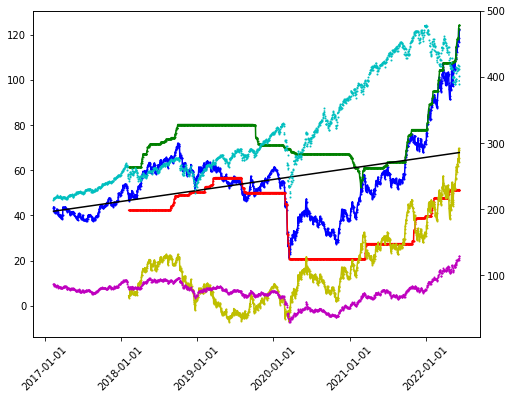

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[108.41493596222088, 1245.5228624957929, 112.44556688717778, 106.80608239338595]
best model: ets_FF
best score: 106.80608239338595
sell date: 2022-09-11
expected return: 0.06353848380720972


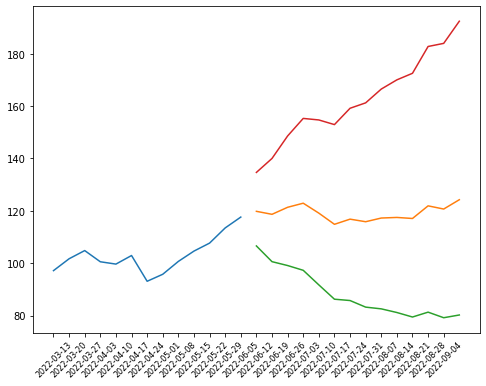

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           9.71
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       7.68
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             34.92
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  140.509995  116.071949  130.762381  145.452813  113.398095   

              90dSDev 90d_lower   90d_upper  
2022-06-10  16.061488  81.27512  145.521071

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
VLO      1.213534  140.509995  84050366.565809  0.943432  0.970961  0.536721

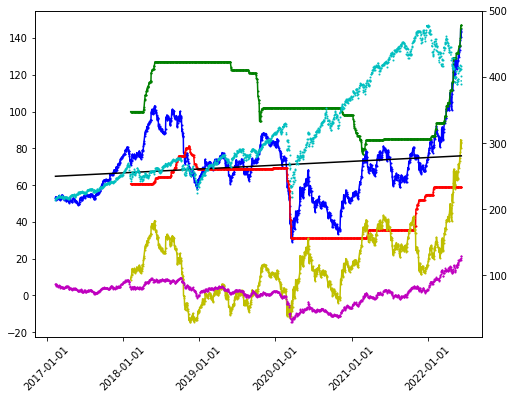

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[184.44390132509653, 1681.8179284666796, 191.59805140594946, 183.1360897934775]
best model: ets_FF
best score: 183.1360897934775
sell date: 2022-08-28
expected return: 0.06843745185327069


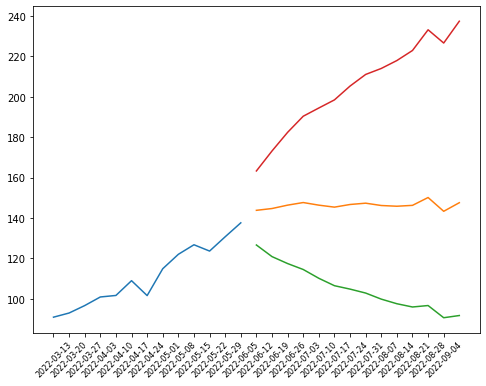

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                       Value
2022-5                                     
palmOil                               False
controversialWeapons                  False
gambling                              False
socialScore                            7.23
nuclear                               False
furLeather                            False
alcoholic                             False
gmo                                   False
catholic                              False
socialPercentile                       None
peerCount                                39
governanceScore                        4.98
environmentPercentile                  None
animalTesting                         False
tobacco                               False
totalEsg                              30.94
highestControversy                        3
esgPerformance                     OUT_PERF
coal                                  False
p

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA   90dSDev  \
2022-06-10     144.0  116.478407  133.361588  150.24477  124.478413  8.803147   

             90d_lower   90d_upper  
2022-06-10  106.872118  142.084708

volume_factor latest_p      vol_30d_2yr  pct_2yr       adf     hurst
EOG       0.92473    144.0  86714140.166415  0.96583  0.922673  0.487021

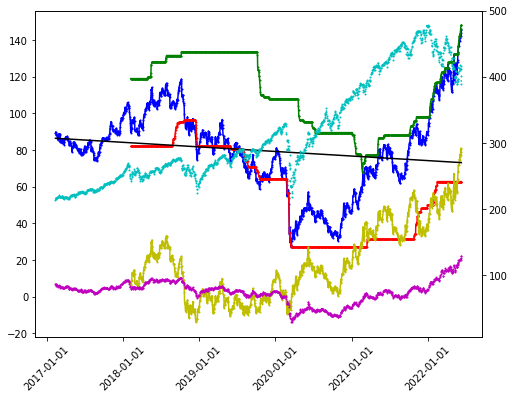

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[272.35000754446645, 5680.059079883269, 279.12129887710756, 272.10461355891454]
best model: ets_FF
best score: 272.10461355891454
sell date: 2022-09-11
expected return: 0.11678685813492962


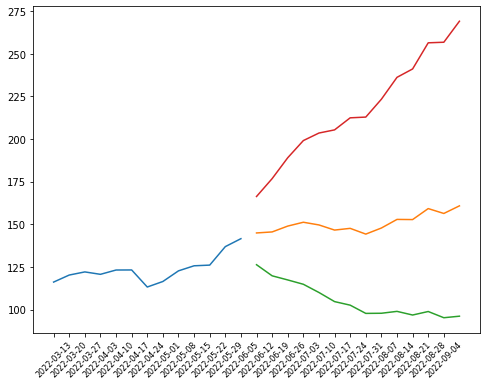

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   6.087000e+09  6.058000e+09  6.017000e+09   
Total Liab                        1.605600e+10  1.540700e+10  1.600400e+10   
Total Stockholder Equity          2.218000e+10  2.176500e+10  2.088100e+10   
Other Current Liab                1.523000e+09  1.224000e+09  1.698000e+09   
Total Assets                      3.823600e+10  3.717200e+10  3.688500e+10   
Common Stock                      2.060000e+08  2.060000e+08  2.060000e+08   
Other Current Assets              4.560000e+08  3.810000e+08  5.130000e+08   
Retained Earnings                 1.591900e+10  1.554200e+10  1.468900e+10   
Other Liab                        6.384000e+09  6.844000e+09  6.916000e+09   
Treasury Stock                   -3.200000e+07 -4.100000e+07 -3.100000e+07   
Other Assets                      4.830000e+08  1.278000e+09  1.291000e+09   
Cash                              5.

Adj Close   21dBOLD  21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  68.260002  65.61324  69.11873  72.624221  67.673228  2.145514   

            90d_lower  90d_upper  
2022-06-10  63.382199  71.964256

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf     hurst
WRB      1.310112  68.260002  23023001.53177  0.886168  0.965152  0.455795

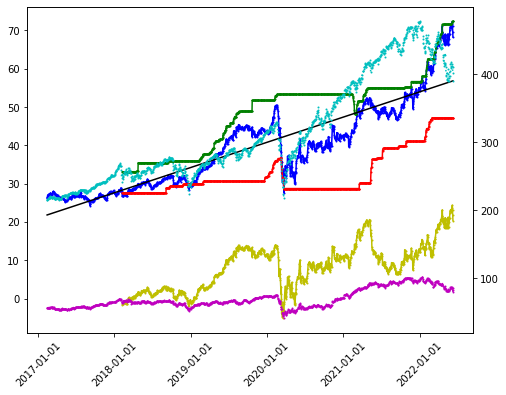

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[62.69614178883496, 961.7660840853787, 63.66556784264645, 53.05575735724623]
best model: ets_FF
best score: 53.05575735724623
sell date: 2022-08-07
expected return: 0.06893959191732095


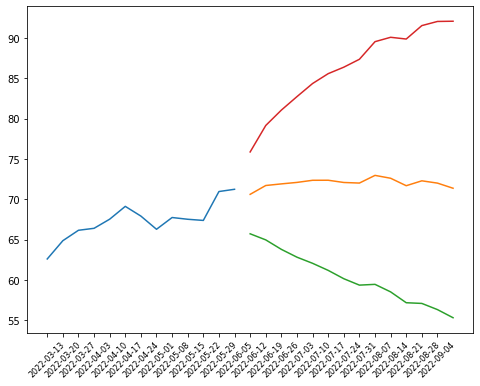

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Total Stockholder Equity          6.653011e+09  6.653011e+09  6.648441e+09   
Net Tangible Assets               6.398359e+09  6.398359e+09  6.478789e+09   
Intangible Assets                          NaN  7.611450e+08  6.626360e+08   
Capital Surplus                            NaN  1.016372e+09  1.018300e+09   
Total Liab                                 NaN  2.541868e+10  2.488058e+10   
Minority Interest                          NaN  1.471900e+07  1.527000e+07   
Other Current Liab                         NaN  4.923033e+09  4.770052e+09   
Total Assets                               NaN  3.208641e+10  3.154429e+10   
Common Stock                               NaN  7.053500e+07  7.053500e+07   
Other Current Assets                       NaN  3.045964e+09  2.919056e+09   
Retained Earnings                          NaN  9.015135e+09  8.920334e+09   
Other Liab                          

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-10  127.720001  108.176953  120.776666  133.37638  111.593174   

             90dSDev 90d_lower   90d_upper  
2022-06-10  8.990912  93.61135  129.574999

volume_factor    latest_p      vol_30d_2yr   pct_2yr      adf     hurst
HES      0.637367  127.720001  66701550.453858  0.961499  0.97499  0.449233

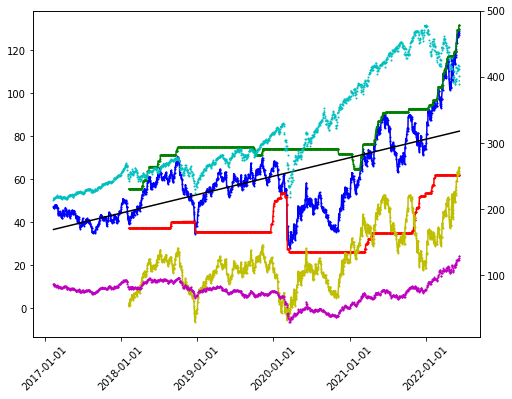

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[184.30771700845568, 1429.0137976179442, 183.5931080499654, 182.86578004178133]
best model: ets_FF
best score: 182.86578004178133
sell date: 2022-09-11
expected return: 0.09678824633941858


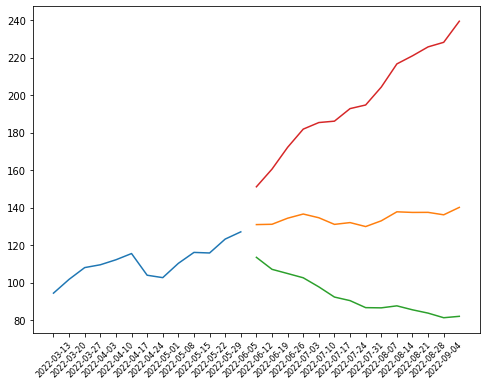

['options', ('2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           6.36
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       6.97
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             31.78
highestControversy                       2
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close  21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10     52.91  47.5295  52.432841  57.336183  45.364921  7.530586   

            90d_lower  90d_upper  
2022-06-10  30.303748  60.426093

volume_factor latest_p    vol_30d_2yr   pct_2yr       adf     hurst
CEIX      1.511199    52.91  9591390.71618  0.883884  0.933936  0.522101

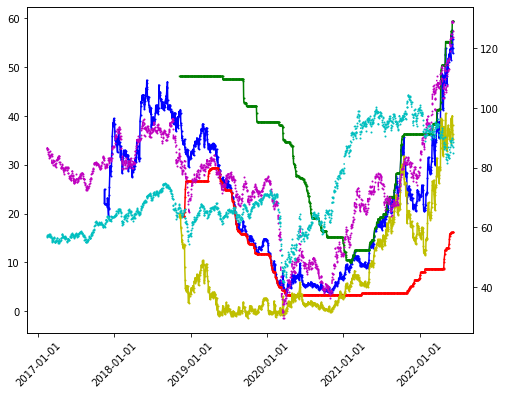

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[nan, nan, nan, nan]
best model: ets_TT
best score: nan
sell date: 2022-08-28
expected return: 0.27550006301727425


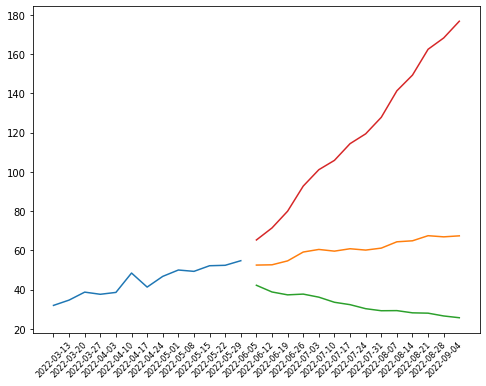

['quarterly_balance_sheet',                                     2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus                   6.469450e+08  6.449200e+08  6.430330e+08   
Total Liab                        1.900704e+09  2.105167e+09  1.965198e+09   
Total Stockholder Equity          6.728130e+08  4.845800e+08  5.927330e+08   
Other Current Liab                1.790310e+08  2.688430e+08  1.451780e+08   
Total Assets                      2.573517e+09  2.589747e+09  2.557931e+09   
Common Stock                      3.450000e+05  3.450000e+05  3.450000e+05   
Other Current Assets              3.747200e+07  4.242800e+07  3.166900e+07   
Retained Earnings                 2.809600e+08  1.636370e+08  2.774260e+08   
Other Liab                        8.455480e+08  9.379920e+08  9.285180e+08   
Treasury Stock                   -2.554370e+08 -3.243220e+08 -3.280710e+08   
Other Assets                      5.153480e+08  5.008660e+08  4.742010e+08   
Cash                              1.

Adj Close     21dBOLD    21dMA-TP    21dBOLU      90dSMA  \
2022-06-10  155.490005  120.025332  143.822381  167.61943  138.226666   

             90dSDev   90d_lower  90d_upper  
2022-06-10  9.525387  119.175893  157.27744

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
FANG      1.227123  155.490005  49440914.674735  0.951302  0.837164  0.472651

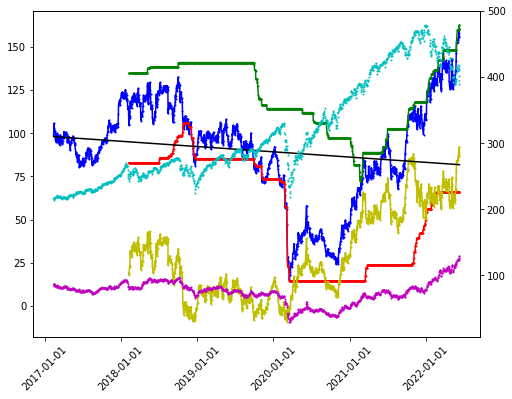

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[423.4047758397133, 1748.1382328733205, 437.55604705023154, 422.6826829939061]
best model: ets_FF
best score: 422.6826829939061
sell date: 2022-09-11
expected return: 0.14510888959442717


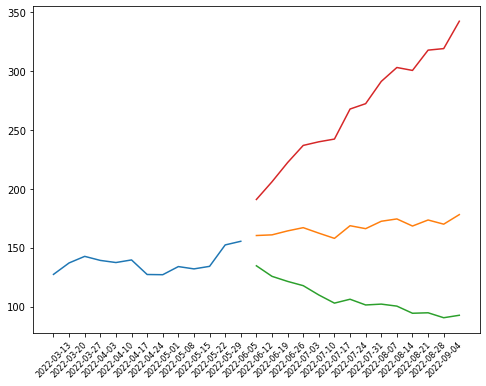

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
symbol: CIVI
sector: Energy
Index: SP600
supply trend: 7642718.420574887
risk trend factor: 2.668131309107495
         beta currentRatio debtToEquity dividendRate dividendYield     ebitda  \
CIVI  1.69646        0.505       11.399         1.85        0.0222  910931008   

     ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
CIVI       0.54408  5.807773    855249152      0.79951    731177000   

     heldPercentInstitutions       industry   marketCap operatingCashflow  \
CIVI                 1.04378  Oil & Gas E&P  7110930432         764176000   

     operatingMargins payoutRatio pegRatio priceToBook  \
CIVI          0.26443      0.2792      0.4    1.532868   

     priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
CIVI                     4.247195       0.16167      0.477        0.06714   

     returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
CIVI        0.09524   

Adj Close  21dBOLD   21dMA-TP    21dBOLU    90dSMA   90dSDev  \
2022-06-10  80.660004  56.1793  72.431587  88.683875  64.55873  7.871397   

            90d_lower  90d_upper  
2022-06-10  48.815937  80.301523

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf    hurst
CIVI      2.177131  80.660004  7642718.420575  0.942041  0.020246  0.49614

ADFuller H0 rejected @ .05, Mean Reverting TS
Month Mean Reverting buy signal


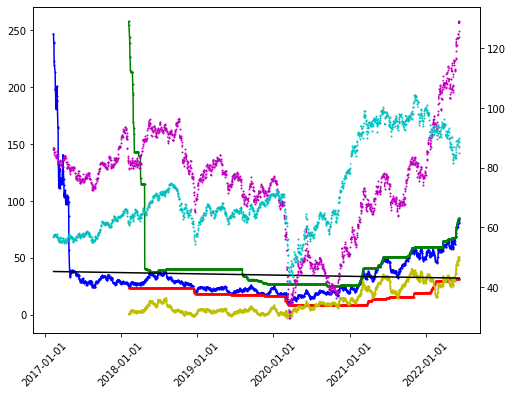

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[100.99523033499905, 2235.886585688372, 82.91037472891489, 103.79785809107564]
best model: ets_TF
best score: 82.91037472891489
sell date: 2022-08-28
expected return: 0.17929864516732902


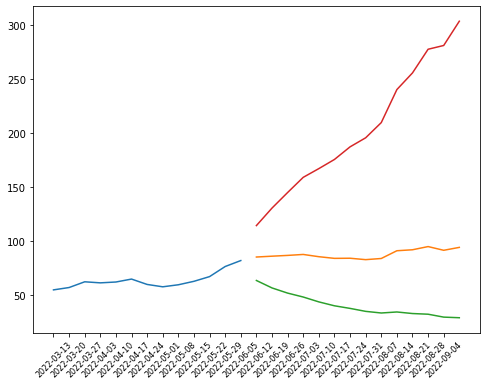

['options', ('2022-07-15', '2022-12-16')]
symbol: NFG
sector: Energy
Index: SP400
supply trend: 11033521.558245083
risk trend factor: 2.6550357052664886
         beta currentRatio debtToEquity dividendRate dividendYield  \
NFG  0.723039        0.633      132.864         1.82        0.0271   

    earningsGrowth      ebitda ebitdaMargins  forwardPE freeCashflow  \
NFG          0.694  1026038976        0.5552  13.185118    113741128   

    grossMargins grossProfits heldPercentInstitutions              industry  \
NFG      0.61861   1095026000                 0.75657  Oil & Gas Integrated   

      marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
NFG  6624960512         758292992          0.37081      0.3534      1.2   

    priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
NFG    3.708525                     3.584827       0.22633       0.45   

    returnOnAssets returnOnEquity revenueGrowth revenuePerShare  sector  \
NFG        0.05856        0.2

Adj Close    21dBOLD   21dMA-TP   21dBOLU     90dSMA   90dSDev  \
2022-06-10  72.650002  66.029887  71.394603  76.75932  70.114762  2.669158   

            90d_lower  90d_upper  
2022-06-10  64.776446  75.453077

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
NFG      0.912129  72.650002  11033521.558245  0.912861  0.982328  0.468009

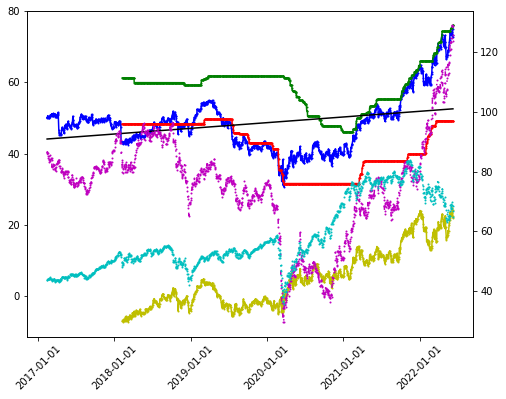

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[23.208236807713128, 69.07518426066642, 23.080219291457585, 23.277824636403416]
best model: ets_TF
best score: 23.080219291457585
sell date: 2022-08-07
expected return: 0.09494729474772362


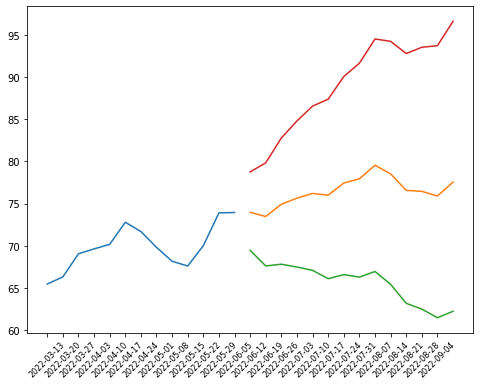

['quarterly_balance_sheet',                              2021-12-31    2021-09-30    2021-06-30  \
Capital Surplus            1.013821e+09  1.017446e+09  1.012703e+09   
Total Liab                 5.479478e+09  5.678619e+09  5.197561e+09   
Total Stockholder Equity   2.110195e+09  1.786206e+09  2.011114e+09   
Deferred Long Term Liab    2.536600e+08  2.290640e+08  3.343380e+08   
Other Current Liab         4.894420e+08  8.377480e+08  4.037490e+08   
Total Assets               7.589673e+09  7.464825e+09  7.208675e+09   
Common Stock               9.143700e+07  9.118200e+07  9.117300e+07   
Other Current Assets       6.503700e+07  1.509440e+08  2.513100e+07   
Retained Earnings          1.281963e+09  1.191175e+09  1.145700e+09   
Other Liab                 1.952837e+09  1.794161e+09  1.969099e+09   
Good Will                  5.476000e+06  5.476000e+06  5.476000e+06   
Treasury Stock            -2.770260e+08 -5.135970e+08 -2.384620e+08   
Other Assets               4.572680e+08  4.239440

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  84.129997  58.883591  74.841111  90.798632  73.113968  5.744648   

            90d_lower  90d_upper  
2022-06-10  61.624671  84.603265

volume_factor   latest_p      vol_30d_2yr   pct_2yr      adf     hurst
PDCE      1.125975  84.129997  26294633.055976  0.935258  0.76826  0.495944

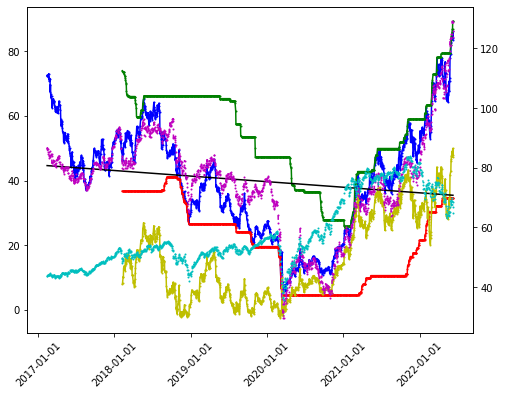

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[148.31228930492983, 806.894650409446, 156.61027246059032, 148.70340092560062]
best model: ets_TT
best score: 148.31228930492983
sell date: 2022-08-28
expected return: 0.12130617549801379


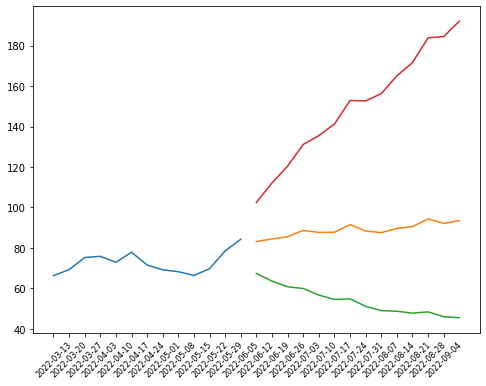

['options', ('2022-07-15', '2022-12-16')]
symbol: OXY
sector: Energy
Index: SP500
supply trend: 312554843.6459909
risk trend factor: 2.6206123783270985
         beta currentRatio debtToEquity dividendRate dividendYield  \
OXY  1.955081        1.156      111.198         0.52        0.0075   

          ebitda ebitdaMargins forwardPE freeCashflow grossMargins  \
OXY  15392000000       0.53054  8.023869   9129875456      0.64697   

    grossProfits heldPercentInstitutions       industry    marketCap  \
OXY  16297000000                 0.82201  Oil & Gas E&P  59858386944   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
OXY       12762999808          0.25255      0.0242     0.27    3.952352   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
OXY                     2.063229       0.25314      0.844        0.05964   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
OXY        0.34101         0.577       

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  63.869999  60.711375  66.862064  73.012753  61.107143  4.905649   

            90d_lower  90d_upper  
2022-06-10  51.295845  70.918441

volume_factor   latest_p       vol_30d_2yr  pct_2yr       adf     hurst
OXY      1.797943  63.869999  312554843.645991  0.84478  0.777852  0.546207

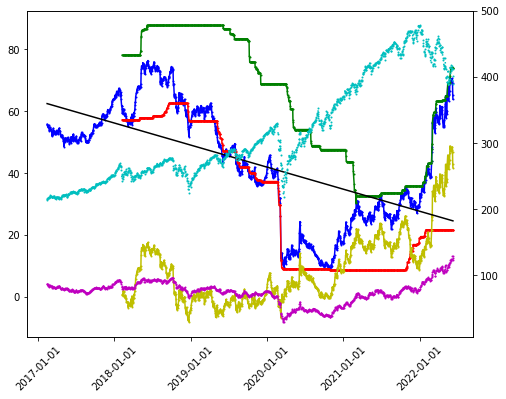

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[168.49397026031474, 346.4607706800462, 170.42773172733027, 168.4939232595021]
best model: ets_FF
best score: 168.4939232595021
sell date: 2022-09-11
expected return: 0.3024726047644143


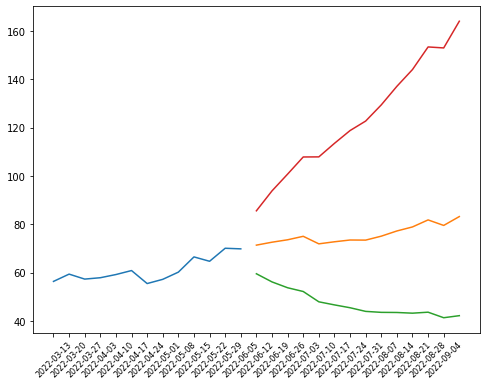

['options', ('2022-06-17', '2022-08-19', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                          12.04
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                       6.88
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             43.53
highestControversy                       2
esgPerformance                   LEAD_PERF
coal                                 False
pesticid

Adj Close     21dBOLD    21dMA-TP     21dBOLU      90dSMA  \
2022-06-10  270.869995  256.919894  273.316666  289.713438  255.561587   

              90dSDev   90d_lower   90d_upper  
2022-06-10  15.927793  223.706001  287.417173

volume_factor    latest_p      vol_30d_2yr   pct_2yr       adf     hurst
PXD      1.167952  270.869995  41581229.500756  0.916981  0.935146  0.498349

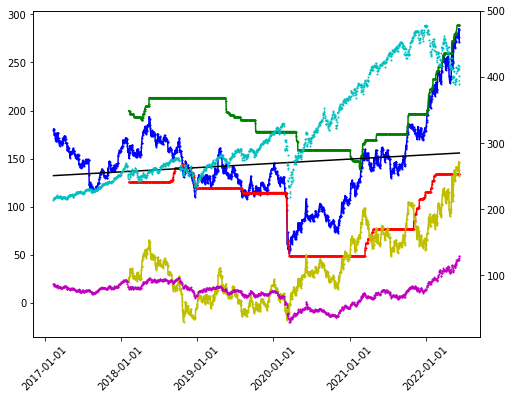

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[1066.0576841401642, 4693.227892088648, 1060.6774465764013, 1067.5551592634004]
best model: ets_TF
best score: 1060.6774465764013
sell date: 2022-09-11
expected return: 0.09584372036029556


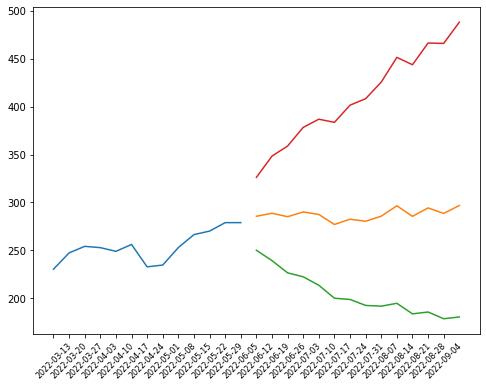

['options', ('2022-06-17', '2023-01-20', '2024-01-19')]
['sustainability',                                      Value
2022-5                                    
palmOil                              False
controversialWeapons                 False
gambling                             False
socialScore                           8.97
nuclear                              False
furLeather                           False
alcoholic                            False
gmo                                  False
catholic                             False
socialPercentile                      None
peerCount                               66
governanceScore                        9.1
environmentPercentile                 None
animalTesting                        False
tobacco                              False
totalEsg                             36.53
highestControversy                       1
esgPerformance                    OUT_PERF
coal                                 False
pesticides            

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA  90dSDev  \
2022-06-10     23.24  18.125204  21.358571  24.591938  20.760794  1.50283   

            90d_lower  90d_upper  
2022-06-10  17.755134  23.766453

volume_factor latest_p     vol_30d_2yr   pct_2yr       adf     hurst
CNX       0.90438    23.24  79583176.67171  0.940271  0.784231  0.406859

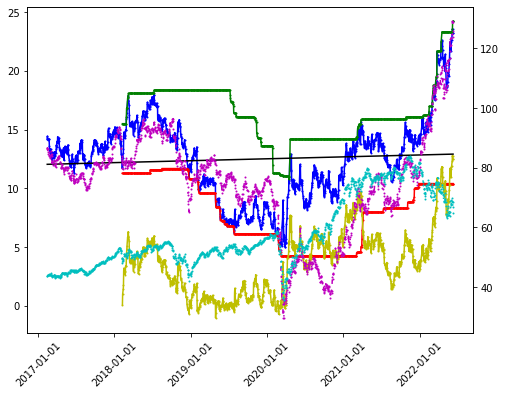

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[3.9855006112640794, 25.5188753200386, 3.8384892769132906, 3.98529604146771]
best model: ets_TF
best score: 3.8384892769132906
sell date: 2022-07-10
expected return: 0.07047670619007071


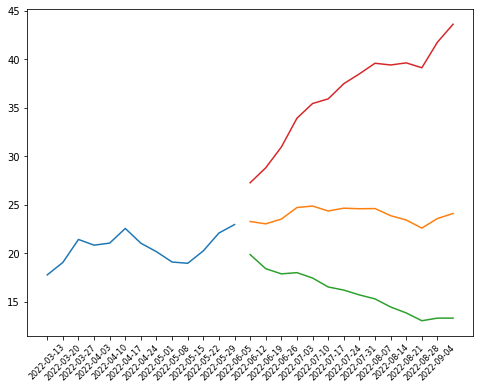

['options', ('2022-07-15', '2023-01-20')]
symbol: MTDR
sector: Energy
Index: SP400
supply trend: 50876450.52950076
risk trend factor: 2.5519542477276707
          beta currentRatio debtToEquity dividendRate dividendYield  \
MTDR  4.053921        0.997       64.085          0.2        0.0044   

     earningsGrowth      ebitda ebitdaMargins  forwardPE freeCashflow  \
MTDR          2.392  1377725952       0.66904  10.304898     33695376   

     grossMargins grossProfits heldPercentInstitutions       industry  \
MTDR      0.84283   1462239000                 0.93761  Oil & Gas E&P   

       marketCap operatingCashflow operatingMargins payoutRatio pegRatio  \
MTDR  7653827584        1212914048          0.49033      0.0245     0.42   

     priceToBook priceToSalesTrailing12Months profitMargins quickRatio  \
MTDR    4.525147                     3.716796        0.3552      0.801   

     returnOnAssets returnOnEquity revenueGrowth revenuePerShare  sector  \
MTDR        0.15195        0.405

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  65.230003  43.121122  57.022299  70.923475  54.485794  5.169552   

           90d_lower  90d_upper  
2022-06-10  44.14669  64.824898

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf    hurst
MTDR      0.613531  65.230003  50876450.529501  0.95853  0.987482  0.46805

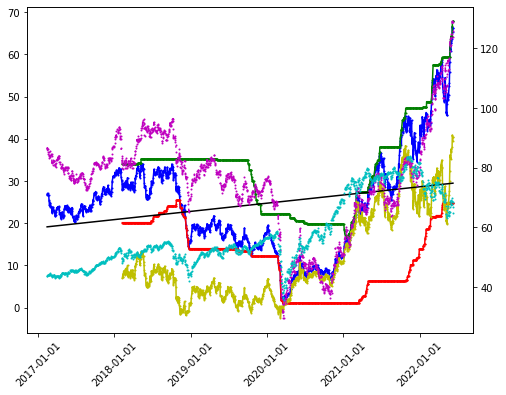

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[41.93883170193044, 199.97206151254173, 35.843015115435485, 41.953025576391816]
best model: ets_TF
best score: 35.843015115435485
sell date: 2022-09-11
expected return: 0.16299345066282958


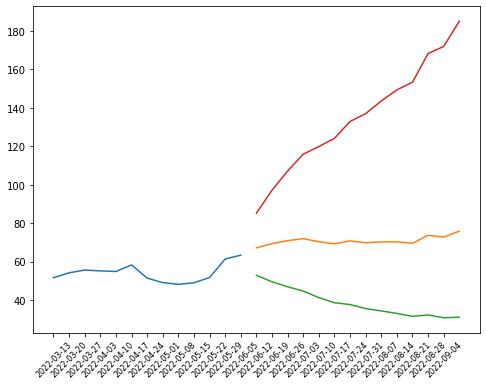

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus                   2.087788e+09  2.077592e+09  2.069484e+09   
Total Liab                        2.229864e+09  2.134765e+09  2.077593e+09   
Total Stockholder Equity          2.118600e+09  1.907210e+09  1.688007e+09   
Minority Interest                 2.188640e+08  2.201780e+08  2.198930e+08   
Other Current Liab                3.095620e+08  2.075790e+08  2.648190e+08   
Total Assets                      4.567328e+09  4.262153e+09  3.985493e+09   
Common Stock                      1.181000e+06  1.179000e+06  1.172000e+06   
Other Current Assets              5.734600e+07  4.075600e+07  3.782000e+07   
Retained Earnings                 2.994000e+07 -1.713180e+08 -3.802680e+08   
Other Liab                        1.939550e+08  1.269630e+08  6.975800e+07   
Treasury Stock                   -3.090000e+05 -2.430000e+05 -2.381000e+06   
Other Assets                      3.

Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  56.369999  41.96407  50.064286  58.164501  42.669841  6.172185   

            90d_lower 90d_upper  
2022-06-10  30.325472  55.01421

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
DINO      0.964968  56.369999  51935930.332829  0.948909  0.412505  0.562704

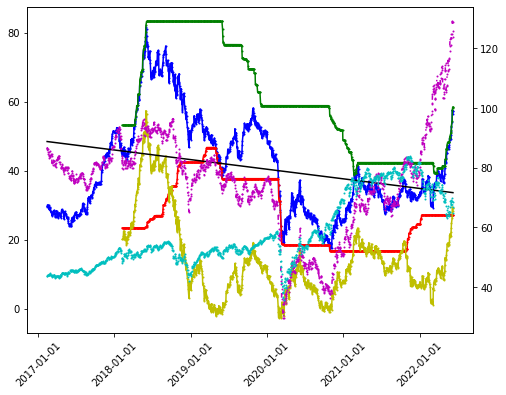

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[132.20764640385852, 686.6426166686189, 191.50236854871565, 133.33273303311915]
best model: ets_TT
best score: 132.20764640385852
sell date: 2022-08-28
expected return: -0.03676758982800798


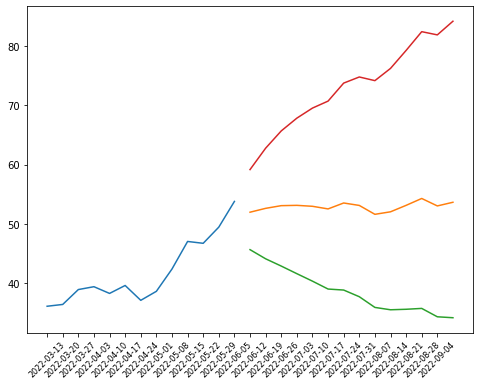

symbol: HRB
sector: Consumer Cyclical
Index: SP400
supply trend: 61640658.16944024
risk trend factor: 2.3710165833660994
         beta currentRatio debtToEquity dividendRate dividendYield  \
HRB  0.695099        1.103     5314.905         1.08        0.0298   

    earningsGrowth     ebitda ebitdaMargins forwardPE grossMargins  \
HRB         -0.008  806428032       0.30238   9.67663        0.472   

    grossProfits heldPercentInstitutions           industry   marketCap  \
HRB   1400058000                 0.93154  Personal Services  5683142656   

    operatingCashflow operatingMargins payoutRatio pegRatio priceToBook  \
HRB          80728000          0.25066      0.3344     1.05   126.72598   

    priceToSalesTrailing12Months profitMargins quickRatio revenueGrowth  \
HRB                     2.130946       0.16063      0.971         0.039   

    revenuePerShare             sector sharesOutstanding shortRatio  \
HRB          15.645  Consumer Cyclical         159594000       4.71   

 

Adj Close    21dBOLD   21dMA-TP    21dBOLU 90dSMA  90dSDev  \
2022-06-10  35.450001  30.968201  34.265079  37.561958  29.09  3.96819   

            90d_lower  90d_upper  
2022-06-10  21.153621  37.026379

volume_factor   latest_p     vol_30d_2yr   pct_2yr       adf    hurst
HRB      1.155552  35.450001  61640658.16944  0.941968  0.838883  0.43511

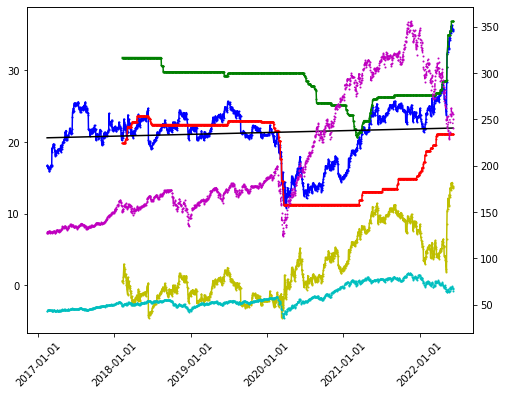

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[10.193927445487516, 38.246433616611185, 9.882083658594022, 10.19370246644311]
best model: ets_TF
best score: 9.882083658594022
sell date: 2022-08-07
expected return: 0.07650640247887168


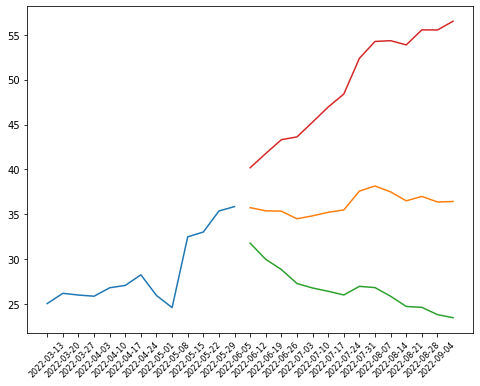

['options', ('2022-07-15', '2023-01-20', '2024-01-19')]
symbol: MUR
sector: Energy
Index: SP400
supply trend: 60623530.18154312
risk trend factor: 2.3198869089480696
        beta currentRatio debtToEquity dividendRate dividendYield      ebitda  \
MUR  2.55625          0.6       80.704          0.7        0.0161  1488126976   

    ebitdaMargins forwardPE freeCashflow grossMargins grossProfits  \
MUR       0.48315  5.593307   1159256320      0.81723   2271014000   

    heldPercentInstitutions       industry   marketCap operatingCashflow  \
MUR                 0.83585  Oil & Gas E&P  6752466944        1522727040   

    operatingMargins payoutRatio pegRatio priceToBook  \
MUR          0.21109      0.7836     0.18    1.674372   

    priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
MUR                     2.192315       0.03261      0.533        0.03902   

    returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
MUR        0.06042         0.47

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  44.150002  31.102213  39.549445  47.996677  39.439424  3.288115   

            90d_lower  90d_upper  
2022-06-10  32.863194  46.015654

volume_factor   latest_p      vol_30d_2yr   pct_2yr       adf     hurst
MUR      0.567049  44.150002  60623530.181543  0.957721  0.869435  0.455651

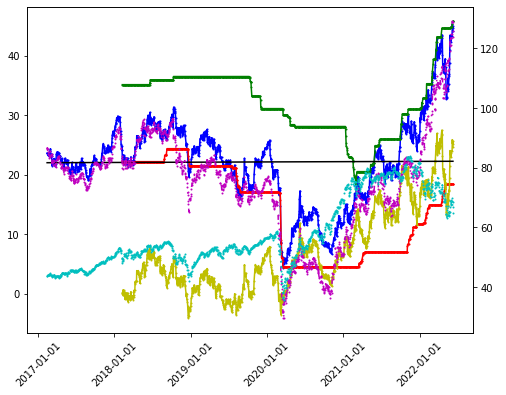

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[36.299883272184005, 137.35884922926851, 36.22355289856092, 36.333277819474354]
best model: ets_TF
best score: 36.22355289856092
sell date: 2022-09-11
expected return: 0.13201884292074983


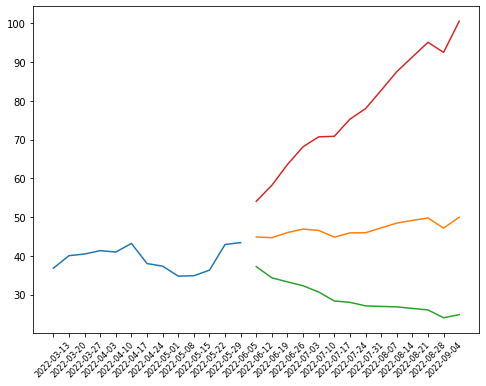

['options', ('2022-06-17', '2022-07-15', '2022-12-16', '2023-01-20', '2024-01-19')]
symbol: SM
sector: Energy
Index: SP600
supply trend: 82761362.10287443
risk trend factor: 2.2682714381373863
        beta currentRatio debtToEquity dividendRate dividendYield      ebitda  \
SM  5.488235        0.717       93.916         0.02        0.0006  1315937024   

   ebitdaMargins  forwardPE freeCashflow grossMargins grossProfits  \
SM       0.45427  10.711865    570353344       0.8671   2136878000   

   heldPercentInstitutions       industry   marketCap operatingCashflow  \
SM                 0.88028  Oil & Gas E&P  6141725696        1396240000   

   operatingMargins payoutRatio pegRatio priceToBook  \
SM          0.18012       0.007     0.12    3.752134   

   priceToSalesTrailing12Months profitMargins quickRatio returnOnAssets  \
SM                     2.120158       0.11608        0.7        0.06264   

   returnOnEquity revenueGrowth revenuePerShare  sector sharesOutstanding  \
SM        0

Adj Close    21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  50.560001  30.683761  44.192381  57.701002  40.420635  5.240911   

            90d_lower  90d_upper  
2022-06-10  29.938813  50.902457

volume_factor   latest_p      vol_30d_2yr  pct_2yr       adf     hurst
SM      0.612742  50.560001  82761362.102874  0.91777  0.976245  0.479096

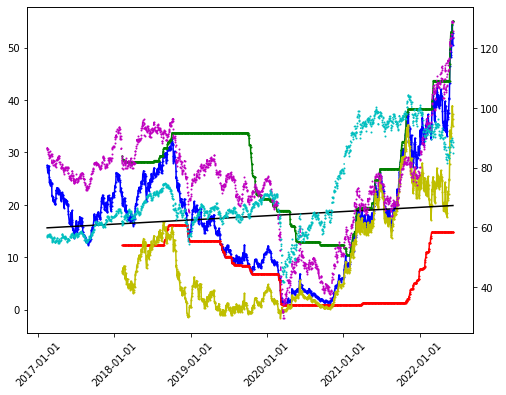

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[36.8304353932524, 159.27137663694862, 40.32131488904999, 37.8965213427182]
best model: ets_TT
best score: 36.8304353932524
sell date: 2022-09-11
expected return: 0.7323244376637932


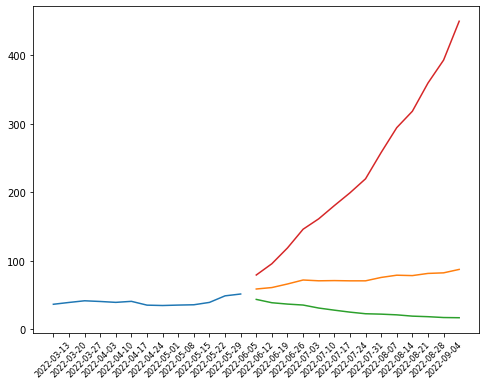

['quarterly_balance_sheet',                              2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus            1.844478e+09  1.840228e+09  1.838620e+09   
Total Liab                 3.280672e+09  3.170846e+09  3.425061e+09   
Total Stockholder Equity   2.115109e+09  2.063131e+09  1.636899e+09   
Deferred Long Term Liab    2.300000e+06  2.700000e+06  3.100000e+06   
Other Current Liab         5.381270e+08  4.047460e+08  5.520440e+08   
Total Assets               5.395781e+09  5.233977e+09  5.061960e+09   
Common Stock               1.219000e+06  1.219000e+06  1.215000e+06   
Other Current Assets       9.649000e+06  2.409500e+07  2.451400e+07   
Retained Earnings          2.820790e+08  2.345330e+08 -1.903670e+08   
Other Liab                 2.415590e+08  1.809150e+08  2.438640e+08   
Treasury Stock            -1.266700e+07 -1.284900e+07 -1.256900e+07   
Other Assets               5.397300e+07  2.576600e+07  6.020700e+07   
Cash                       4.198870e+08  3.327160

Adj Close   21dBOLD   21dMA-TP    21dBOLU     90dSMA   90dSDev  \
2022-06-10  34.439999  24.99917  32.004603  39.010036  30.735397  2.964719   

            90d_lower  90d_upper  
2022-06-10  24.805959  36.664834

volume_factor   latest_p       vol_30d_2yr   pct_2yr       adf     hurst
RRC      0.617091  34.439999  159173207.564297  0.907293  0.784588  0.495379

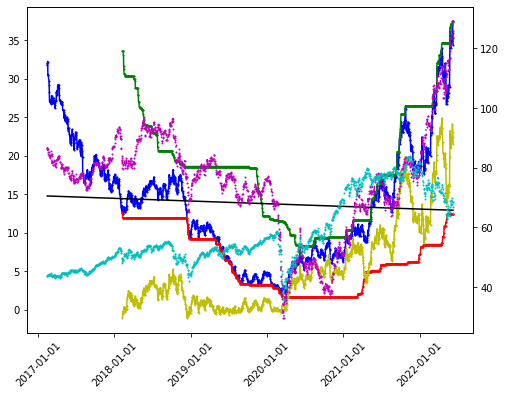

ets next 13 weeks
['ets_TT', 'ets_FT', 'ets_TF', 'ets_FF']
[12.719719618082797, 42.82753462549841, 9.614877280805164, 13.051782047842186]
best model: ets_TF
best score: 9.614877280805164
sell date: 2022-09-11
expected return: 0.2654205581520757


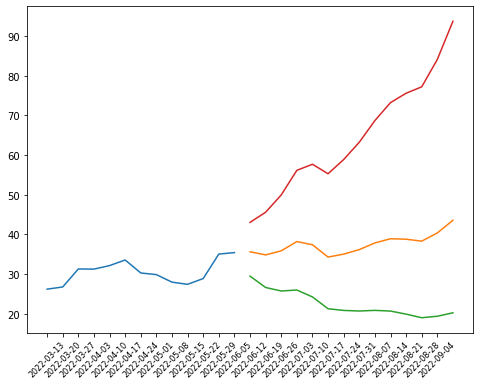

['quarterly_balance_sheet',                                     2022-03-31    2021-12-31    2021-09-30  \
Capital Surplus                   5.707652e+09  5.720277e+09  5.707382e+09   
Total Liab                        4.960181e+09  4.574844e+09  5.122905e+09   
Total Stockholder Equity          1.600104e+09  2.085663e+09  1.181284e+09   
Other Current Liab                9.381210e+08  2.591970e+08  7.840350e+08   
Total Assets                      6.560285e+09  6.660507e+09  6.304189e+09   
Common Stock                      2.627000e+06  2.598000e+06  2.598000e+06   
Other Current Assets              2.033800e+07  5.738000e+06  4.518200e+07   
Retained Earnings                -4.063941e+09 -3.607055e+09 -4.498421e+09   
Other Liab                        7.692500e+08  6.897480e+08  7.182680e+08   
Treasury Stock                   -4.623400e+07 -3.015700e+07 -3.027500e+07   
Other Assets                      1.585190e+08  1.133600e+08  1.039020e+08   
Cash                              1.

In [184]:
client = Client('192.168.3.100:8786')

tscv = expanding_window(initial =52*2, horizon = 13,period = 26)

batchClearLimit = round(len(list__)/7)

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
 
print("adf < .05 or .01, mean reverting")
print("Hurst")
print("> .5 - The time series is mean reverting.")
print("= .5 - The time series is a Geometric Brownian Motion.")
print("< .5 - The time series is trending.")
"""*spdr_indexes['Symbol'].values,*vanguard_sectors['Symbol'].values,"""
for s in list__:
    msize = 2

    metrics_df_ = pd.DataFrame(pd.DataFrame(screener.loc[s].dropna()).T[['volume_factor','latest_p','vol_30d_2yr','pct_2yr','adf','hurst']])

    subset=prices[prices['Symbol']==s].reindex(nyse_dates.index).interpolate(method='time')

    dates = []
    for t in subset.index.values:
        d = pd.Timestamp(t).strftime('%Y-%m-%d')
        dates.append(d)
        dto = datetime.strptime(d, '%Y-%m-%d').date()

    old_ordinal = [datetime.strptime(i, '%Y-%m-%d').toordinal() for i in dates]
    new_ordinal = old_ordinal + md.date2num(np.datetime64('0000-12-31'))
    x = new_ordinal    

    lookup_index_ = []

    labels = list()
    print("symbol:",s)   

    try:
        symbol_sector = dict_sectors[sector_merged[sector_merged['Symbol']==s]['Sector'].values[0]]
        print("sector:",dict_sectors_reverse[symbol_sector])
    except:
        if(symbol_sector=='error'):
            if(np.sum([vanguard_sectors['Symbol'].values==s])):
                symbol_sector = s
                print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
    if(symbol_sector=='error'):
        if(np.sum([vanguard_sectors['Symbol'].values==s])):
            symbol_sector = s
            print("sector:",dict_sectors_reverse[symbol_sector])
        else:
            symbol_sector = 'error'
            print("sector:",'error')
    """
    if(symbol_sector=='error'):
        try:
            dict_sectors[symbol_sector]
            symbol_sector = dict_sectors_reverse[s]
        except:
            pass
    """

    symbol_index = temp_sm.loc[s]['index_Symbol']

    try:
        matched_index_name = spdr_indexes.iloc[np.where(spdr_indexes['Symbol'].values==s)].index[0]
    except:
        try:
            matched_index_name = temp_sm.loc[s]['index']
        except:
            matched_index_name = "none"

    print("Index:",matched_index_name)

    print("supply trend:",screener.iloc[np.where(screener.index==s)]['vol_30d_2yr'][0])
    print("risk trend factor:",screener.iloc[np.where(screener.index==s)]['risk_trend_factor'][0])   

    temp = pd.DataFrame(stock_fundamentals.loc[s])
    print(temp[np.array(temp!='error')].replace([np.inf,'inf','error', -np.inf], np.nan).dropna().T)

    last_date = pd.DataFrame(subset.iloc[-1][['21dBOLD','21dMA-TP','21dBOLU']],index=[prices[prices['Symbol']==s].index[-1].strftime('%Y-%m-%d')]).index[0]
    #print(last_date)
    bbands = pd.DataFrame(subset.iloc[-1][['Adj Close','21dBOLD','21dMA-TP','21dBOLU','90dSMA','90dSDev']]).T
    bbands['90d_lower'] = bbands['90dSMA']-bbands['90dSDev']*2
    bbands['90d_upper'] = bbands['90dSMA']+bbands['90dSDev']*2
    
    #print(bbands)
    bbands.index = [last_date]
    display(bbands)

    display(metrics_df_)
    
    if(metrics_df_['adf'][0]<.05):
        print("ADFuller H0 rejected @ .05, Mean Reverting TS")
        if(bbands['Adj Close'][0]<bbands['90d_lower'][0]):
            colored_text = colored(255, 0, 0, "Quarter Mean Reverting buy signal")
            print(colored_text)
        if(bbands['Adj Close'][0]<bbands['21dBOLU'][0]):
            colored_text = colored(255, 0, 0, "Month Mean Reverting buy signal")
            print(colored_text)
    
    fig, ax1 = plt.subplots()   
    
    ax2 = ax1.twinx()
    
    l_axis_legend = pd.DataFrame(['symbol', 'trailing_1yr_max', 'trailing_1yr_min', 'linear','supply_trend_1yr'],index=['blue','green','red','black','yellow'],columns=['legend'])
    #display(l_axis_legend)
    r_axis_legend = pd.DataFrame(['sector','index'],index=['magenta','cyan'],columns=['legend'])
    #display(r_axis_legend)

    display_side_by_side([l_axis_legend, r_axis_legend], ['l axis', 'r axis'])
        
    #labels_ax2 = list()
    #if(np.sum(spdr_indexes['Symbol'].values==s)>0):    
    
    if(symbol_sector=='error'):
        pass
        """
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            #print("sector:",dict_sectors_reverse[s])
            ax2.plot(x, prices[prices['Symbol']==s]['Adj Close'],marker = '.',markersize=msize)
            #plt.plot(prices[prices['Symbol']==s]['Adj Close'])
            labels.append(dict_sectors_reverse[s])
            #plt.legend([dict_sectors_reverse[s]])
            #plt.show()
        elif((temp_sm.loc[s]['Sector']=='error')):
            #print("pass")
            pass
        """
    else:
        if(np.sum(vanguard_sectors['Symbol'].values==s)>0):
            pass
        else:
            #print("sector",)
            #print("else_sector:",dict_sectors_reverse[s])
            ax2.plot(x, prices[prices['Symbol']==symbol_sector]['Adj Close'],marker = '.',markersize=msize,color='m',linestyle=(0, (3, 10, 1, 10)))        
            #plt.legend([temp_sm.loc[s]['Sector']])
            #labels_ax2.append(temp_sm.loc[s]['Sector'])
            #plt.show()

    if(str(temp_sm.loc[s]['index_Symbol'])!='nan'):
        if(temp_sm.loc[s]['index_Symbol']!='error'):
            #print(temp_sm.loc[s]['index_Symbol'])
            ax2.plot(x, prices[prices['Symbol']==temp_sm.loc[s]['index_Symbol']]['Adj Close'],marker = '.',markersize=msize,color='c',linestyle=(0, (1, 10)))
            #plt.plot()
            #plt.legend([temp_sm.loc[s]['index']])
            #labels_ax2.append(temp_sm.loc[s]['index'])
            #plt.show()

    y= subset['Adj Close']

    slope, intercept, r, p, std_err = stats.linregress(x, y)

    mymodel = list(map(myfunc, x))

    ax1.plot(x, y,marker = '.',markersize=msize, color = 'b')
    ax1.plot(x, subset['trailing_1yr_max'],marker = '.',markersize=msize, color = 'g')
    ax1.plot(x, subset['trailing_1yr_min'],marker = '.',markersize=msize, color = 'r')
    
    #plt.plot(x, subset['21dBOLD'],marker = '.',markersize=msize)
    #plt.plot(x, subset['21dBOLU'],marker = '.',markersize=msize)
    #plt.plot(x, subset['21dMA-TP'],marker = '.',markersize=msize)
    #plt.plot(x, subset['90dSMA'],marker = '.',markersize=msize)
    #plt.plot(x, subset['90dSMA']+subset['90dSDev']*2,marker = '.',markersize=msize)
    #plt.plot(x, subset['90dSMA']-subset['90dSDev']*2,marker = '.',markersize=msize)
    
    ax1.plot(x, subset['supply_trend_1yr'],marker = '.',markersize=msize, color = 'y')
    
    ax1.plot(x, mymodel, color = 'k')
    
    #for l in ['1yrMax','1yrMin','21dBOLD','21dBOLU','21dMA-TP','90dSMA','90dSMA+Sdev*2','90dSMA-Sdev*2','supply_trend_1yr','linear']:
    for l in ['symbol','1yrMax','1yrMin','supply_trend_1yr','linear']:
        labels.append(l)

    """
    if(lookup_sector_ == 'error'):
        labels.append(['1yrMax','1yrMin','21dBOLD','21dBOLU','21dMA-TP','90dSMA','90dSMA+Sdev*2','90dSMA-Sdev*2','supply_trend_1yr','linear'])
    else:
        labels = ['1yrMax','1yrMin','21dBOLD','21dBOLU','21dMA-TP','90dSMA','90dSMA+Sdev*2','90dSMA-Sdev*2','supply_trend_1yr','linear']
    """
    #ax1.legend([*labels,*labels_ax2], fontsize=8,loc=2)
    #ax1.legend(labels_ax2, fontsize=8,loc=2)
    
    l = matplotlib.dates.AutoDateLocator()
    f = matplotlib.dates.ConciseDateFormatter(l)    
    
    ax1.set_xticklabels(ax1.get_xticks(), rotation = 45)
    
    locator = matplotlib.dates.AutoDateLocator()
    formatter = matplotlib.dates.ConciseDateFormatter(locator)

    ax1.xaxis.set_major_locator(locator)
    ax1.xaxis.set_major_formatter(formatter)
    
    date_form = DateFormatter("%Y-%m-%d")
    ax1.xaxis.set_major_formatter(date_form)
    plt.show()
    
    print("ets next 13 weeks")
    
    #ets_LAdA=sm.tsa.statespace.ExponentialSmoothing(np.log(subset['Adj Close'].asfreq('D').interpolate().asfreq('W')),initialization_method='heuristic',seasonal=52,trend=True,damped_trend=True).fit()
    #ets_LAdA_ndt=sm.tsa.statespace.ExponentialSmoothing(np.log(subset['Adj Close'].asfreq('D').interpolate().asfreq('W')),initialization_method='heuristic',seasonal=52,trend=False,damped_trend=True).fit()

    newDates = pd.date_range(end, (end + dt.timedelta(92)).strftime('%Y-%m-%d'), freq='W').map(lambda t: t.strftime('%Y-%m-%d'))

    data = subset[['Adj Close']].asfreq('D').interpolate().asfreq('W')

    if(np.where(np.array(list__)==s)[0][0]%batchClearLimit==0):        
        client.restart()
        
    npa = []
    for train_index, test_index in tscv.split(data):

        train = data.iloc[train_index]
        test = data.iloc[test_index]

        npa.append([train,test])
    
    future = client.map(evaluate_ets, npa)
    results_rmses = []

    #my intent was to capture future objects vs results and this gave me results
    for f in as_completed(future):
        #exclude errors
        if(f.status=="error"):
            #pass
            results_rmses.append([np.nan,np.nan,np.nan,np.nan])
        else:
            results_rmses.append(f.result()) 

    rmse_TT = [r[0] for r in results_rmses].copy()
    rmse_FT = [r[1] for r in results_rmses].copy()
    rmse_TF = [r[2] for r in results_rmses].copy()
    rmse_FF = [r[3] for r in results_rmses].copy()

    del results_rmses
    del npa
        
    models = ['ets_TT','ets_FT','ets_TF','ets_FF']
    print(models)
    #scores = [np.mean(rmse_TT),np.mean(rmse_FT),np.mean(rmse_TF),np.mean(rmse_FF),np.mean(rmse_arima)]
    scores = [np.mean(rmse_TT),np.mean(rmse_FT),np.mean(rmse_TF),np.mean(rmse_FF)]
    print(scores)

    best_model = models[np.argmin(scores)]

    print("best model:",best_model)
    print("best score:",scores[np.argmin(scores)])

    if(best_model=='ets_TT'):
        final_model=sm.tsa.statespace.ExponentialSmoothing(np.log(data),initialization_method='heuristic',seasonal=52,trend=True,damped_trend=True).fit()
    elif(best_model=='ets_FT'):
        final_model=sm.tsa.statespace.ExponentialSmoothing(np.log(data),initialization_method='heuristic',seasonal=52,trend=False,damped_trend=True).fit()
    elif(best_model=='ets_TF'):
        final_model=sm.tsa.statespace.ExponentialSmoothing(np.log(data),initialization_method='heuristic',seasonal=52,trend=True,damped_trend=False).fit()
    elif(best_model=='ets_FF'): 
        final_model=sm.tsa.statespace.ExponentialSmoothing(np.log(data),initialization_method='heuristic',seasonal=52,trend=False,damped_trend=False).fit()
    else:
        pass

    pred = final_model.get_prediction(start=end,end=(end + dt.timedelta(92)).strftime('%Y-%m-%d'))
    df_pred = np.exp(pred.summary_frame(alpha=0.05))
    print("sell date:",df_pred.index[np.argmax(df_pred['mean'].values)].strftime('%Y-%m-%d'))
    print("expected return:",np.array((np.max(df_pred['mean'].values)-metrics_df_['latest_p'])/metrics_df_['latest_p'])[0])
    
    plt.plot(data.tail(13))
    plt.plot(df_pred[['mean','mean_ci_lower','mean_ci_upper']])
    plt.xticks([*data.tail(13).index.map(lambda t: t.strftime('%Y-%m-%d')),*newDates],rotation = 45,size=8)
    plt.show()

    #display(pd.DataFrame(stock_fundamentals.set_index(stock_fundamentals.iloc[:,0]).loc[s]).dropna().T)
    
    #evaluate_models(subset['Adj Close'].values, p_values, d_values, q_values)
    
    if(np.sum(np.array(fundamental_entries)==s)>0):
        loc = np.where(np.array(fundamental_entries)==s)[0][0]
        #print(fundamentals_quarterlies[loc[0]][0])
        #fundamentals_quarterlies[loc][1]
        for item in fundamentals_quarterlies[loc][1]:
            if(type(item[1]) == type(None)):
                pass
            else:
                if(len(item[1])>0):
                    #print(len(item[1]))
                    print(item)
client.close()